<a href="https://colab.research.google.com/github/jespimentel/api_cnj/blob/main/anpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final - Deep Learning
> - **Disciplina:** Deep Learning
> - **Curso:** Mestrado em Administração Pública
> - **Área de Concentração:** Ciência de Dados e Inteligência Artificial
> - **Docente Responsável:** Danny de Castro
> - **Ano e Bimestre de Referência:** 2025/2
> - **Alunos:** Fabiana da Silva Guimarães Milhomem e Mairton Damasceno Cunha
---    

#### 1) Instala Bibliotecas, caso não estejam presentes no Jupyter Notebook

In [1]:
# ===================================================================================================
# [1] Instalação das bibliotecas do Jupyter Notebook
# ===================================================================================================

import sys
import subprocess
import importlib

def install_if_missing(package_name, import_name=None):
    if import_name is None:
        import_name = package_name

    if importlib.util.find_spec(import_name) is None:
        print(f"Instalando '{package_name}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
    else:
        print(f"'{package_name}' já está instalado.")

required_packages = [
    ("pandas", "pandas"),
    ("requests", "requests"),
    ("selenium", "selenium"),
    ("webdriver-manager", "webdriver_manager"),
    ("openpyxl", "openpyxl"),
    ("beautifulsoup4", "bs4"),     
    ("lxml", "lxml"),
    ("ipython", "IPython"),
    ("spacy", "spacy"),
    ("genderbr", "genderbr"),
]

for pkg, imp in required_packages:
    install_if_missing(pkg, imp)

# Instala o modelo do spaCy para português, se necessário
import spacy
try:
    nlp = spacy.load("pt_core_news_sm")
except OSError:
    print("Baixando o modelo pt_core_news_sm do spaCy...")
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "pt_core_news_sm"])
    nlp = spacy.load("pt_core_news_sm")

print("\nVerificação concluída!")

'pandas' já está instalado.
'requests' já está instalado.
'selenium' já está instalado.
'webdriver-manager' já está instalado.
'openpyxl' já está instalado.
'beautifulsoup4' já está instalado.
'lxml' já está instalado.
'ipython' já está instalado.
'spacy' já está instalado.
'genderbr' já está instalado.

Verificação concluída!


#### 2) Importa Bibliotecas necessárias

In [2]:
# ===================================================================================================
# [2] Imports de bibliotecas necessárias
# ===================================================================================================
import os
import pandas as pd
import requests
import sys
import io
import json
import ast
import time
import re
import sys
import shutil
import unicodedata
import traceback
import random
import html as _html
import itertools
import unicodedata
from datetime import datetime
from typing import Optional
from pathlib import Path
from collections import Counter
import genderbr  # usado para consulta à base IBGE (inferência de gênero)

# Parsing HTML
from bs4 import BeautifulSoup
import lxml  # garante parser rápido disponível

# Exibição no Jupyter
from IPython.display import display, HTML

# Selenium + WebDriver Manager
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options as ChromeOptions
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.options import Options as FirefoxOptions
from selenium.webdriver.edge.service import Service as EdgeService
from selenium.webdriver.edge.options import Options as EdgeOptions
from webdriver_manager.microsoft import EdgeChromiumDriverManager

# Tokenização de Texto e Pré-Processamento
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

# Análise de Sentimentos - Modelos Clássicos e Probabilísticos
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import pipeline

# Confirmação visual
display(HTML("""
<div style="padding:12px;background-color:#e0ffe5;border-left:6px solid #27ae60;
            font-family:Arial,sans-serif;font-size:14px;border-radius:5px;margin-top:10px;">
    <b> Todas as bibliotecas foram importadas com sucesso!</b>
</div>
"""))

#### 3) Configurações constantes (DataJud + movimentos de sentença)

In [3]:
# ===================================================================================================
# [3] Configurações e constantes (DataJud + movimentos de sentença)
# ===================================================================================================

# Chave pública da API CNJ
API_KEY = "APIKey cDZHYzlZa0JadVREZDJCendQbXY6SkJlTzNjLV9TRENyQk1RdnFKZGRQdw=="

# Endpoint TJAL (DataJud)
DATAJUD_URL = "https://api-publica.datajud.cnj.jus.br/api_publica_tjal/_search"
HEADERS = {"Authorization": API_KEY, "Content-Type": "application/json"}

# Classe e Assunto-alvo (FILTRO selecionado após analisar qtde total de processos com código sem filtro)
CLASSE_ALVO = "Procedimento Comum Cível"
ASSUNTO_ALVO = "Indenização por Dano Moral"

# Movimentos de SENTENÇA (decisões finais de 1º grau)
SENTENCA_MOVS = {
    "Procedência",
    "Procedência em Parte",
    "Julgado procedente em parte",
    "Improcedência",
    "Sentença",
    "Sentença - Procedência do pedido",
    "Sentença - Improcedência do pedido",
    "Sentença - Procedência parcial do pedido",
    "Sentença - Sem Resolução de Mérito",
    "Homologação de Transação",
    "Homologação de Acordo em Execução ou em Cumprimento de Sentença",
    "Extinção da execução ou do cumprimento da sentença",
    "Com Resolução do Mérito",
    "Definitivo",
    "Trânsito em julgado"
}

# Heurísticas adicionais para fallback (quando nome exato não bate)
RESULTADO_CHAVES = {
    "proced", "improced", "parcial", "mérito", "merito",
    "sentença", "sentenca", "homolog", "trânsito", "transito",
    "extinção", "extincao", "definitivo"
}

print(f" Configurações carregadas: {len(SENTENCA_MOVS)} movimentos alvo definidos para Sentenças.")

 Configurações carregadas: 15 movimentos alvo definidos para Sentenças.


#### 4) Funções auxiliares (query, paginação, normalização, filtros)

In [4]:
# ===================================================================================================
# [4] Funções auxiliares - query, paginação, normalização e filtros
# ===================================================================================================

print(f"Não apresenta resultados na console. Apenas carrega funções auxiliares para outras seções. Pode executar a seção [5].")

def build_query(classe_nome: str, assunto_nome: str, sentenca_movs: set):
    """Constroi a query Elastic com match_phrase para classe + assunto e 'should' para movimentos de sentença."""
    should_clauses = [{"match_phrase": {"movimentos.nome": m}} for m in sentenca_movs]
    query = {
        "bool": {
            "must": [
                {"match": {"grau": "G1"}},  # 1º grau
                {"match_phrase": {"classe.nome": classe_nome}},  # classe definida na seção [3]
                {"match_phrase": {"assuntos.nome": assunto_nome}},  # assunto definido na seção [3]
                {"bool": {"should": should_clauses, "minimum_should_match": 1}}
            ]
        }
    }
    return query

def collect_datajud_search_after(url, headers, query, size=1000, sort_field="dataAjuizamento", order="desc", max_pages=None):
    """
    Coleta dados do DataJud usando 'search_after' (recomendado pelo CNJ).
    Retorna lista de _source dos hits.
    """
    all_sources = []
    last_sort = None
    pages = 0

    while True:
        payload = {
            "size": size,
            "query": query,
            "sort": [{sort_field: {"order": order}}],
        }
        if last_sort:
            payload["search_after"] = last_sort

        resp = requests.post(url, headers=headers, json=payload)
        resp.raise_for_status()
        data = resp.json()
        hits = data.get("hits", {}).get("hits", [])

        if not hits:
            break

        # agrega fontes e atualiza 'last_sort'
        for h in hits:
            src = h.get("_source", {})
            all_sources.append(src)
        last_sort = hits[-1].get("sort", None)

        pages += 1
        if max_pages and pages >= max_pages:
            print(f" Interrompido após {pages} páginas por max_pages.")
            break

        # pequeno intervalo para ser gentil com a API
        time.sleep(0.5)

    print(f"Registros coletados (DataJud): {len(all_sources)}")
    return all_sources

def normalize_datajud_records(records):
    """
    Normaliza os campos: base (campos simples), assuntos (lista), movimentos (lista).
    Retorna três DataFrames: df_base, df_assuntos, df_movimentos.
    """
    # Base
    base_rows = []
    ass_rows = []
    mov_rows = []

    for r in records:
        base_rows.append({
            "numeroProcesso": r.get("numeroProcesso"),
            "tribunal": r.get("tribunal"),
            "grau": r.get("grau"),
            "dataAjuizamento": r.get("dataAjuizamento"),
            "orgaoJulgador_codigo": (r.get("orgaoJulgador") or {}).get("codigo"),
            "orgaoJulgador_nome": (r.get("orgaoJulgador") or {}).get("nome"),
            "classe_codigo": (r.get("classe") or {}).get("codigo"),
            "classe_nome": (r.get("classe") or {}).get("nome"),
        })

        # Assuntos
        for a in (r.get("assuntos") or []):
            ass_rows.append({
                "numeroProcesso": r.get("numeroProcesso"),
                "assunto_codigo": a.get("codigo"),
                "assunto_nome": a.get("nome"),
            })

        # Movimentos
        for m in (r.get("movimentos") or []):
            mov_rows.append({
                "numeroProcesso": r.get("numeroProcesso"),
                "mov_codigo": m.get("codigo"),
                "mov_nome": m.get("nome"),
                "mov_data": m.get("dataHora", None),  # alguns TJs têm timestamp
                "mov_complementos": m.get("complementosTabelados"),  # pode ser lista/dict
            })

    df_base = pd.DataFrame(base_rows)
    df_assuntos = pd.DataFrame(ass_rows)
    df_mov = pd.DataFrame(mov_rows)

    # Tipos/parse de datas
    for col in ["dataAjuizamento", "mov_data"]:
        if col in df_base.columns:
            df_base[col] = pd.to_datetime(df_base[col], errors="coerce", utc=True)
        if col in df_mov.columns:
            df_mov[col] = pd.to_datetime(df_mov[col], errors="coerce", utc=True)

    return df_base, df_assuntos, df_mov

def assunto_ok_row(row_ass_nome: str, alvo: str) -> bool:
    """Retorna True se o nome do assunto contém o alvo."""
    if not isinstance(row_ass_nome, str):
        return False
    return alvo.lower() in row_ass_nome.lower()


def is_sentenca_mov(nome: str) -> bool:
    """
    Verifica se o nome do movimento é de SENTENÇA usando nomes exatos + heurísticas.
    """
    if not isinstance(nome, str) or not nome.strip():
        return False
    nomel = nome.lower()
    # nomes exatos
    if nome in SENTENCA_MOVS:
        return True
    # heurística: contém "sentença" e algum resultado
    if "sentença" in nomel and any(k in nomel for k in RESULTADO_CHAVES):
        return True
    # NOVO: reconhecer variações comuns
    padroes = [
        "julgado improcedente o pedido",
        "julgada improcedente o pedido",
        "julgo improcedente",
        "julgado procedente o pedido",
        "julgada procedente o pedido",
        "julgo procedente",
        "julgado procedente em parte o pedido",
        "julgada procedente em parte o pedido",
        "Julgado procedente em parte do pedido",
        "julgo procedente em parte",
        "procedente",
        "improcedente",
        "parcial",
        "mérito",
        "merito",
        "homolog",
        "trânsito",
        "transito",
        "extinção",
        "extincao",
        "definitivo"
    ]
    if any(p in nomel for p in padroes):
        return True
    # fallback mínimo: alguns tribunais registram "Julgamento"
    if nomel == "julgamento":
        return True
    return False

Não apresenta resultados na console. Apenas carrega funções auxiliares para outras seções. Pode executar a seção [5].


#### 5) Coleta DataJud (sentenças), normalização e salvamento

In [5]:
# ===================================================================================================
# [5] Coleta DataJud (SENTENÇAS), normalização, filtros e salvamento
# ===================================================================================================

print(f"Aguarde a consulta de processos na API do DataJud...")

# 5.0) Construir query e coletar registros do DataJud (A query inicial reduz o universo bruto, mas não garante a qualidade dos dados)
query = build_query(CLASSE_ALVO, ASSUNTO_ALVO, SENTENCA_MOVS)
records = collect_datajud_search_after(
    url=DATAJUD_URL,
    headers=HEADERS,
    query=query,
    size=1000,   # cada requisição traz até 1000 processos
    sort_field="dataAjuizamento",
    order="desc",
    max_pages=None   # continua coletando até não haver mais registros
)
print(f"Coleta concluída. Total bruto de registros: {len(records)}")

# 5.1) Deduplicação inicial por número de processo
def dedup_por_numero(records):
    vistos = set()
    unicos = []
    for r in records:
        np = str(r.get("numeroProcesso", "")).strip()
        if not np or np in vistos:
            continue
        vistos.add(np)
        unicos.append(r)
    return unicos

records = dedup_por_numero(records)
print(f"Registros após deduplicação inicial (sem duplicidade): {len(records)}")

# 5.2) Sanitização leve de 'records'
records_fixed = []
for r in records:
    r2 = dict(r)

    # Normaliza 'assuntos'
    ass = r2.get("assuntos")
    ass_list = []
    if isinstance(ass, dict):
        ass_list = [ass]
    elif isinstance(ass, list):
        tmp = []
        for item in ass:
            if isinstance(item, dict):
                tmp.append(item)
            elif isinstance(item, list):
                tmp.extend([x for x in item if isinstance(x, dict)])
            elif isinstance(item, str):
                try:
                    parsed = json.loads(item)
                    if isinstance(parsed, dict):
                        tmp.append(parsed)
                    elif isinstance(parsed, list):
                        tmp.extend([x for x in parsed if isinstance(x, dict)])
                except Exception:
                    pass
        ass_list = tmp
    elif isinstance(ass, str):
        try:
            parsed = json.loads(ass)
            if isinstance(parsed, dict):
                ass_list = [parsed]
            elif isinstance(parsed, list):
                ass_list = [x for x in parsed if isinstance(x, dict)]
        except Exception:
            ass_list = []
    else:
        ass_list = []
    r2["assuntos"] = ass_list

    # Normaliza 'movimentos'
    mov = r2.get("movimentos")
    mov_list = []
    if isinstance(mov, dict):
        mov_list = [mov]
    elif isinstance(mov, list):
        tmp = []
        for item in mov:
            if isinstance(item, dict):
                tmp.append(item)
            elif isinstance(item, list):
                tmp.extend([x for x in item if isinstance(x, dict)])
            elif isinstance(item, str):
                try:
                    parsed = json.loads(item)
                    if isinstance(parsed, dict):
                        tmp.append(parsed)
                    elif isinstance(parsed, list):
                        tmp.extend([x for x in parsed if isinstance(x, dict)])
                except Exception:
                    pass
        mov_list = tmp
    elif isinstance(mov, str):
        try:
            parsed = json.loads(mov)
            if isinstance(parsed, dict):
                mov_list = [parsed]
            elif isinstance(parsed, list):
                mov_list = [x for x in parsed if isinstance(x, dict)]
        except Exception:
            mov_list = []
    else:
        mov_list = []
    r2["movimentos"] = mov_list

    records_fixed.append(r2)

# 5.3) Normaliza usando função definida anteriormente
df_base, df_ass, df_mov = normalize_datajud_records(records_fixed)

# 5.4) Deduplicação dos DataFrames principais
df_base = df_base.drop_duplicates(subset=["numeroProcesso"]).reset_index(drop=True)
df_ass  = df_ass.drop_duplicates(subset=["numeroProcesso", "assunto_codigo", "assunto_nome"]).reset_index(drop=True)
df_mov  = df_mov.drop_duplicates(subset=["numeroProcesso", "mov_codigo", "mov_nome", "mov_data"]).reset_index(drop=True)

# 5.5) Filtro por Classe + Assunto (contém o alvo)
mask_classe = df_base["classe_nome"].fillna("").str.lower() == CLASSE_ALVO.lower()
ass_filtrados = df_ass[df_ass["assunto_nome"].apply(lambda s: isinstance(s, str) and ASSUNTO_ALVO.lower() in s.lower())]
procs_ass_ok = set(ass_filtrados["numeroProcesso"])
mask_assunto = df_base["numeroProcesso"].isin(procs_ass_ok)

df_base_filtrado = df_base[mask_assunto & mask_classe].copy()
df_base_filtrado = df_base_filtrado.drop_duplicates(subset=["numeroProcesso"]).reset_index(drop=True)

# ===================================================================================================
# [5.5a] Filtro adicional: somente processos com assunto único = "Indenização por Dano Moral"
# ===================================================================================================
assuntos_por_processo = (
    df_ass.groupby("numeroProcesso")["assunto_nome"]
          .apply(lambda x: [s if isinstance(s, str) else "" for s in x.tolist()])
)

processos_somente_alvo = assuntos_por_processo[
    assuntos_por_processo.apply(lambda lst: len(lst) == 1 and ASSUNTO_ALVO.lower() in lst[0].lower())
].index.tolist()

print(f"Total de processos SOMENTE com '{ASSUNTO_ALVO}': {len(processos_somente_alvo)}")

df_base_filtrado_somente_alvo = df_base_filtrado[df_base_filtrado["numeroProcesso"].isin(processos_somente_alvo)].copy()

# 5.6) Heurística ampla para identificar movimentos de sentença

def _is_sentenca_mov_amplo(nome: str) -> bool:
    """
    Verifica se o nome do movimento é de SENTENÇA usando nomes exatos + heurísticas.
    Ajuste: exclui movimentos que indicam extinção ou cumprimento de sentença.
    """
    if not isinstance(nome, str) or not nome.strip():
        return False

    n = nome.lower()

    # 1) Movimentos exatos definidos em SENTENCA_MOVS
    if nome in SENTENCA_MOVS:
        return True

    # 2) Contém "sentença" mas não é extinção/cumprimento
    if ("sentença" in n or "sentenca" in n) and not any(x in n for x in ["extinto", "extinção", "cumprimento", "execução"]):
        return True

    # 3) Padrões de resultado (procedente, improcedente, parcial)
    padroes_resultado = [
        "improcedência", "improcedente",
        "procedência", "procedente",
        "procedência em parte", "procedente em parte",
    ]
    if any(p in n for p in padroes_resultado):
        return True

    return False

df_mov_sent = df_mov[df_mov["mov_nome"].apply(_is_sentenca_mov_amplo)].copy()
df_mov_sent = df_mov_sent.drop_duplicates().reset_index(drop=True)
procs_com_sentenca = set(df_mov_sent["numeroProcesso"])

df_sentencas = df_base_filtrado_somente_alvo[
    df_base_filtrado_somente_alvo["numeroProcesso"].isin(procs_com_sentenca)
].copy()
df_sentencas = df_sentencas.drop_duplicates(subset=["numeroProcesso"]).reset_index(drop=True)

df_mov_sent_somente_alvo = df_mov_sent[df_mov_sent["numeroProcesso"].isin(processos_somente_alvo)].copy()

print(f"Processos filtrados (classe & assunto único): {len(df_base_filtrado_somente_alvo)}")
print(f"Processos filtrados com SENTENÇA/decisão final (assunto único): {len(df_sentencas)}")

# ===================================================================================================
# [5.6a] Filtro adicional: movimentos finais relevantes (com normalização)
# ===================================================================================================
def normalizar_texto(txt):
    if not isinstance(txt, str):
        return ""
    txt = txt.lower()
    txt = unicodedata.normalize("NFKD", txt)
    return "".join(c for c in txt if not unicodedata.combining(c))

PADROES_RESULTADO = [
    "procedente", "improcedente", "procedencia",
    "procedente em parte", "procedencia em parte", "procedencia parcial",
    "pedido conhecido em parte", "sentença", "sentenca", "trânsito", "transito"
]

df_mov_sent_somente_alvo["mov_nome_norm"] = df_mov_sent_somente_alvo["mov_nome"].apply(normalizar_texto)
df_mov_sent_somente_alvo = df_mov_sent_somente_alvo[
    df_mov_sent_somente_alvo["mov_nome_norm"].apply(lambda x: any(p in x for p in PADROES_RESULTADO))
].copy()

procs_validos = set(df_mov_sent_somente_alvo["numeroProcesso"])
df_sentencas = df_sentencas[df_sentencas["numeroProcesso"].isin(procs_validos)].copy()

print(f"Processos com movimentos finais relevantes (procedente, improcedente e procedente parcial): {len(df_sentencas)}")

# 5.7) Remover timezone antes de gravar Excel
def _drop_tz(df, cols):
    for c in cols:
        if c in df.columns and pd.api.types.is_datetime64_any_dtype(df[c]):
            df[c] = df[c].dt.tz_localize(None)
    return df

df_base = _drop_tz(df_base, ["dataAjuizamento"])
df_ass = _drop_tz(df_ass, [])
df_mov = _drop_tz(df_mov, ["mov_data"])
df_base_filtrado = _drop_tz(df_base_filtrado, ["dataAjuizamento"])
df_base_filtrado_somente_alvo = _drop_tz(df_base_filtrado_somente_alvo, ["dataAjuizamento"])
df_mov_sent = _drop_tz(df_mov_sent, ["mov_data"])
df_mov_sent_somente_alvo = _drop_tz(df_mov_sent_somente_alvo, ["mov_data"])
df_sentencas = _drop_tz(df_sentencas, ["dataAjuizamento"])

# 5.8) Salvamento — planilha normalizada
OUT_XLSX = "tjal_datajud_normalizado.xlsx"
with pd.ExcelWriter(OUT_XLSX, engine="openpyxl") as xlw:
    df_base.to_excel(xlw, sheet_name="base", index=False)
    df_ass.to_excel(xlw, sheet_name="assuntos", index=False)
    df_mov.to_excel(xlw, sheet_name="movimentos", index=False)
    df_base_filtrado.to_excel(xlw, sheet_name="base_filtrada", index=False)
    df_mov_sent.to_excel(xlw, sheet_name="mov_sentencas", index=False)
    df_base_filtrado_somente_alvo.to_excel(xlw, sheet_name="base_somente_alvo", index=False)
    df_mov_sent_somente_alvo.to_excel(xlw, sheet_name="mov_somente_alvo", index=False)
    df_sentencas.to_excel(xlw, sheet_name="proc_sentenca_final", index=False)

print(f"Planilha normalizada completa salva em: {OUT_XLSX}")

# 5.9) Lista para scraping
def normalizar_numero_cnj(num: str) -> str:
    s = re.sub(r"\D", "", str(num or "").strip())
    return s.zfill(20)

df_lista_somente_alvo = (
    df_sentencas[["numeroProcesso"]]
    .drop_duplicates(subset=["numeroProcesso"])
    .assign(numeroProcesso=lambda d: d["numeroProcesso"].astype(str).map(normalizar_numero_cnj))
    .sort_values("numeroProcesso")
)

OUT_LISTA = "processos_filtrados_TJAL.xlsx"
with pd.ExcelWriter(OUT_LISTA, engine="openpyxl") as xlw:
    df_lista_somente_alvo.to_excel(xlw, sheet_name="lista", index=False)
    ws = xlw.book["lista"]
    for row in ws.iter_rows(min_row=2, min_col=1, max_col=1):
        for cell in row:
            cell.number_format = "@"

print(f"Lista de processos (assunto único '{ASSUNTO_ALVO}') salva em: {OUT_LISTA}")
print(f"Total de processos filtrados para scraping (assunto único): {len(df_lista_somente_alvo)}")

Aguarde a consulta de processos na API do DataJud...
Registros coletados (DataJud): 5477
Coleta concluída. Total bruto de registros: 5477
Registros após deduplicação inicial (sem duplicidade): 5475
Total de processos SOMENTE com 'Indenização por Dano Moral': 2202
Processos filtrados (classe & assunto único): 2202
Processos filtrados com SENTENÇA/decisão final (assunto único): 2201
Processos com movimentos finais relevantes (procedente, improcedente e procedente parcial): 1912
Planilha normalizada completa salva em: tjal_datajud_normalizado.xlsx
Lista de processos (assunto único 'Indenização por Dano Moral') salva em: processos_filtrados_TJAL.xlsx
Total de processos filtrados para scraping (assunto único): 1912


#### 6) Preparação de utilitários para scraping (CNJ, navegador, robots)

In [6]:
# ===================================================================================================
# [6] Utilitários de scraping — e-SAJ TJAL
# ===================================================================================================

ESAJ_URL_G1 = "https://www2.tjal.jus.br/cpopg/open.do"  #portal de serviços do Tribunal TJAL
SAIDA_DIR = Path("SENTENCAS_HTML")  # Salva as movimentações de sentenças neste diretório
SAIDA_DIR.mkdir(exist_ok=True)

# ---------------------------------------------------------------------------------------------------
# Helpers CNJ
# ---------------------------------------------------------------------------------------------------
def normalizar_numero_cnj(num: str) -> str:
    s = re.sub(r"\D", "", str(num or "").strip())
    return s.zfill(20)

def fatiar_cnj(num: str):
    s = normalizar_numero_cnj(num)
    if len(s) != 20 or not s.isdigit():
        raise ValueError(f"Número inválido: {s}")
    nnnnnnn = s[0:7]
    digito   = s[7:9]
    ano      = s[9:13]
    foro     = s[16:20]
    numero_13 = nnnnnnn + digito + ano
    return numero_13, foro

# ---------------------------------------------------------------------------------------------------
# Normalização e validação de nomes
# ---------------------------------------------------------------------------------------------------
_PARTICULAS = {"de","da","do","dos","das","e"}
_NOT_NAME_TOKENS = {
    "É","DEVER","AUTOS","SENTENÇA","SENTENCA","DECISÃO","DESPACHO","RELATÓRIO",
    "PUBLIQUE-SE","REGISTRE-SE","INTIMEM-SE","CUMPRA-SE","P.R.I.","P.R.I",
    "MM","DR","DRA","JUIZ","JUIZA","MAGISTRADO","MAGISTRADA"
}

def _valid_nome_tokens(nome: str) -> bool:
    if not nome or len(nome.strip()) < 5:
        return False
    nome = re.sub(r"\s+", " ", nome).strip()
    toks = re.findall(r"[A-Za-zÁÉÍÓÚÃÕÂÊÔÇa-záéíóúãõâêôç'’-]+", nome)
    if len(toks) < 2:
        return False
    toks_fil = [t for t in toks if t.lower() not in _PARTICULAS]
    if len(toks_fil) < 2:
        return False
    if len(toks_fil[-1]) < 3:
        return False
    blacklist_generic = {
        "como","requerente","vem","perante","este","partir",
        "limites","matéria","discutida","teor","os","pre","quantum"
    }
    if any(t.lower() in blacklist_generic for t in toks_fil):
        return False
    if any(t.lower().endswith(("ar","er","ir")) for t in toks_fil):
        return False
    if any(t.islower() for t in toks_fil):
        return False
    return True

def _beautify_nome(nome: str) -> str:
    if not nome or not nome.strip():
        return ""
    nome = re.sub(r"^[\s\.\-\:\,]+", "", nome.strip())
    nome = re.sub(r"\s+", " ", nome)
    parts = nome.split()
    out = []
    for p in parts:
        if p.lower() in _PARTICULAS:
            out.append(p.lower())
        else:
            out.append(p.capitalize())
    return " ".join(out)

# ---------------------------------------------------------------------------------------------------
# Regex úteis
# ---------------------------------------------------------------------------------------------------
_CARGO_RE = r"(?:MM\.?\s*)?(?:Ju[ií]z(?:a)?(?:\s+de\s+Direito)?|Magistrad[oa]|Desembargador[oa])"

# ---------------------------------------------------------------------------------------------------
# Busca de nome do juiz dentro da sentença
# ---------------------------------------------------------------------------------------------------
def _extrair_nome_esquerda_do_cargo(texto: str) -> str:
    if not texto: return ""
    txt = re.sub(r"\s+", " ", texto).strip()
    for m in re.finditer(_CARGO_RE, txt, flags=re.I):
        left = txt[:m.start()][-600:]
        pat = re.compile(
            r"([A-ZÁÉÍÓÚÃÕÂÊÔÇ][\w’'-]+(?:\s+(?:de|da|do|dos|das|e)\s+[A-ZÁÉÍÓÚÃÕÂÊÔÇ][\w’'-]+)?"
            r"(?:\s+[A-ZÁÉÍÓÚÃÕÂÊÔÇ][\w’'-]+){1,7})\s*$",
            flags=re.I
        )
        mm = pat.search(left)
        if mm:
            cand = mm.group(1).strip()
            if _valid_nome_tokens(cand):
                return _beautify_nome(cand)
    return ""

def _extrair_nome_pos_data(texto: str) -> str:
    if not texto: return ""
    txt = re.sub(r"\s+", " ", texto)
    pat = re.compile(
        r"[A-ZÁÉÍÓÚÃÕÂÊÔÇ][\w\-']+,\s*\d{1,2}\s+de\s+[a-zç]+\s+de\s+\d{4}\.\s+([A-ZÁÉÍÓÚÃÕÂÊÔÇ][A-Za-z’' \-]{5,120}?)\s+Ju[ií]z",
        flags=re.I
    )
    m = pat.search(txt)
    if m and _valid_nome_tokens(m.group(1)):
        return _beautify_nome(m.group(1))
    return ""

def _extrair_nome_por_cargo_global(texto: str) -> str:
    if not texto: return ""
    txt = re.sub(r"\s+", " ", texto)
    pat = re.compile(
        r"((?:[A-ZÁÉÍÓÚÃÕÂÊÔÇ][\w’'-]+(?:\s+(?:de|da|do|dos|das|e)\s+)?){2,10})"
        r"\s*(?:[,.;:\-–—]\s*)?(?:Ju[ií]z(?:a)?(?:\s+de\s+Direito)?)",
        flags=re.I
    )
    m = pat.search(txt)
    if m and _valid_nome_tokens(m.group(1)):
        return _beautify_nome(m.group(1))
    return ""

def _fallback_header_nome(html_path: str) -> str:
    try:
        with open(html_path, "r", encoding="utf-8", errors="ignore") as f:
            soup = BeautifulSoup(f.read(), "lxml")
        el = soup.find("span", id="juizProcesso")
        if el:
            nome = el.get_text(" ", strip=True)
            nome = re.sub(_CARGO_RE, "", nome, flags=re.I)
            nome = nome.strip()
            if _valid_nome_tokens(nome):
                return _beautify_nome(nome)
    except Exception:
        pass
    return "NÃO LOCALIZADO"

def extrair_magistrado_da_movimentacao(sent: dict, html_path: str) -> str:
    MERITO = {"PROCEDENTE","IMPROCEDENTE","PROCEDENTE EM PARTE"}
    classific = (sent.get("classificacao","") or "").upper()
    texto = (sent.get("texto_sentenca") or "").strip()

    if classific in MERITO and texto:
        for func in (_extrair_nome_esquerda_do_cargo,
                     _extrair_nome_pos_data,
                     _extrair_nome_por_cargo_global):
            n = func(texto)
            if _valid_nome_tokens(n):
                return n

    return _fallback_header_nome(html_path)

# ---------------------------------------------------------------------------------------------------
# SCORE dos movimentos
# ---------------------------------------------------------------------------------------------------
def _score_movimento(mov_nome: str, mov_full: str) -> int:
    f = (mov_full or "").upper()
    n = (mov_nome or "").upper()

    if any(x in n for x in ["JULGADO PROCEDENTE O PEDIDO","JULGADO IMPROCEDENTE","JULGADO PROCEDENTE EM PARTE"]):
        return 3

    if any(p in f for p in [
        "JULGO PROCEDENTE","JULGO IMPROCEDENTE","JULGADO PROCEDENTE EM PARTE",
        "PROCEDENCIA","IMPROCEDENCIA"
    ]): return 3

    if "DISPOSITIVO" in f or "JULGO" in f: return 2
    if "SENTENÇA" in f or "DECISÃO" in f: return 1
    if "CUMPRIMENTO DE SENTENÇA" in f: return 0
    return 0

def _parse_data(d: str):
    try:
        return datetime.strptime(d.strip(), "%d/%m/%Y")
    except:
        return None

# ---------------------------------------------------------------------------------------------------
# EXTRAÇÃO DO DISPOSITIVO CORRETO DA SENTENÇA
# ---------------------------------------------------------------------------------------------------
def _buscar_inicio_dispositivo(texto: str):
    if not texto: return -1
    t = texto.lower()
    gatilhos = [
        "iii- dispositivo","dispositivo","isto posto","isso posto","ante o exposto",
        "diante do exposto","pelas razões","pelas razoes","pelo exposto",
        "julgo procedente","julgo improcedente","julgo parcialmente","julgado"
    ]
    best = -1
    for g in gatilhos:
        pos = t.find(g)
        if pos != -1:
            if best == -1 or pos < best:
                best = pos
    return best

def _buscar_fim_dispositivo(texto: str, pos_ini: int):
    if pos_ini < 0: return -1
    tail = texto[pos_ini:]

    m = re.search(r"[A-ZÁÉÍÓÚÃÕÂÊÔÇ][\w\s\-']{2,60},\s*\d{1,2}\s+de\s+[a-zç]+\s+de\s+\d{4}\.", tail, flags=re.I)
    if m: return pos_ini + m.start()

    m = re.search(r"P\.?\s*R\.?\s*I\.?", tail, flags=re.I)
    if m: return pos_ini + m.start()

    m = re.search(r"transitad[ao].+julgado", tail, flags=re.I)
    if m: return pos_ini + m.start()

    m = re.search(r"Ju[ií]z(?:a)?\s+de\s+Direito", tail, flags=re.I)
    if m: return pos_ini + m.start()

    paras = re.split(r"\n{2,}", tail)
    if len(paras) >= 3:
        cutoff = sum(len(p)+2 for p in paras[:3])
        return pos_ini + cutoff

    return -1

def _limpar_assinatura(texto: str):
    if not texto: return ""
    linhas = [l.strip() for l in texto.split("\n") if l.strip()]
    out = []
    for l in linhas:
        if re.search(r"Ju[ií]z(?:a)?\s+de\s+Direito", l, flags=re.I):
            break
        if re.search(r",\s*\d{1,2}\s+de\s+[a-zç]+\s+de\s+\d{4}\.", l, flags=re.I):
            break
        out.append(l)
    return "\n".join(out).strip()

# ---------------------------------------------------------------------------------------------------
# FUNÇÃO PRINCIPAL — extrair_sentenca_html
# ---------------------------------------------------------------------------------------------------
def extrair_sentenca_html(html_path: str) -> dict | None:
    try:
        with open(html_path,"r",encoding="utf-8",errors="ignore") as f:
            soup = BeautifulSoup(f.read(),"lxml")

        candidatos = []
        for tbl in soup.find_all("table"):
            for tr in tbl.find_all("tr"):
                tds = tr.find_all("td")
                if len(tds) >= 3:
                    data = tds[0].get_text(" ",strip=True)
                    mov = tds[2].get_text("\n",strip=True)
                    nome_mov = mov.split("\n")[0].strip()
                    s = _score_movimento(nome_mov,mov)
                    if s > 0:
                        candidatos.append({
                            "data":data,
                            "mov_nome":nome_mov,
                            "mov_full":mov,
                            "score":s,
                            "dt":_parse_data(data)
                        })

        if not candidatos:
            return None

        candidatos.sort(key=lambda x:(x["score"],x["dt"] or datetime.min), reverse=True)
        best = candidatos[0]
        mov_full = best["mov_full"]

        ini = _buscar_inicio_dispositivo(mov_full)
        if ini != -1:
            fim = _buscar_fim_dispositivo(mov_full, ini)
            if fim != -1 and fim > ini:
                bloco = mov_full[ini:fim]
            else:
                bloco = mov_full[ini: ini+1200]
            bloco = _limpar_assinatura(bloco)
            texto_sent = bloco.strip()
        else:
            texto_sent = mov_full.strip()

        def classif(txt):
            t = txt.upper()
            if "PROCEDENTE EM PARTE" in t: return "PROCEDENTE EM PARTE"
            if "JULGO IMPROCEDENTE" in t or "IMPROCEDENTE" in t: return "IMPROCEDENTE"
            if "JULGO PROCEDENTE" in t or "PROCEDENTE" in t: return "PROCEDENTE"
            return "OUTRA"

        classificacao = classif(texto_sent)

        return {
            "data": best["data"],
            "mov_nome": best["mov_nome"],
            "mov_full": mov_full,
            "classificacao": classificacao,
            "texto_sentenca": texto_sent
        }

    except Exception as e:
        return None

# ---------------------------------------------------------------------------------------------------
# DETECÇÃO E INICIALIZAÇÃO DO DRIVER DO NAVEGADOR PARA USO NO SCRAPING
# ---------------------------------------------------------------------------------------------------
def detectar_navegadores():
    navs = []
    if shutil.which("chrome") or shutil.which("google-chrome"):
        navs.append("chrome")
    if shutil.which("firefox"):
        navs.append("firefox")
    if shutil.which("msedge") or shutil.which("edge"):
        navs.append("edge")
    return navs

def iniciar_driver(navegador: str):
    if navegador == "chrome":
        options = ChromeOptions()
        options.add_argument("--headless=new")
        options.add_argument("--disable-gpu")
        return webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
    if navegador == "firefox":
        options = FirefoxOptions()
        options.headless = False
        return webdriver.Firefox(service=FirefoxService(GeckoDriverManager().install()), options=options)
    if navegador == "edge":
        options = EdgeOptions()
        options.add_argument("--headless=new")
        return webdriver.Edge(service=EdgeService(EdgeChromiumDriverManager().install()), options=options)
    raise ValueError("Navegador não suportado.")

print("Seção [6] carregada com sucesso — agora você pode executar a Seção [7].")

Seção [6] carregada com sucesso — agora você pode executar a Seção [7].


#### 7) Scraping no e‑SAJ - TJAL (Raspagem de Dados e Salvamento dos HTMLs)

In [7]:
# ===================================================================================================
# [7] Scraping no e-SAJ (TJAL) — Raspagem de Dados e salvamento dos HTMLs dos resumos das sentenças
# ===================================================================================================

def expandir_movimentacoes(driver, wait):
    """Abre a aba/área de movimentações. Tenta botão 'linkmovimentacoes' e, em fallback, 'Mais'."""
    try:
        btn = wait.until(EC.element_to_be_clickable((By.ID, "linkmovimentacoes")))
        driver.execute_script("arguments[0].click();", btn)
        time.sleep(1.0)
        return
    except Exception:
        pass
    # fallback: botão 'Mais'
    try:
        el = wait.until(EC.element_to_be_clickable((By.XPATH, "//a[contains(.,'Mais')] | //button[contains(.,'Mais')]")))
        driver.execute_script("arguments[0].click();", el)
        time.sleep(1.0)
    except Exception:
        pass

def preencher_formulario_cnj(driver, wait, numero_raw: str):
    """Preenche o formulário do e-SAJ com o número CNJ e aciona a consulta."""
    numero_13, foro = fatiar_cnj(numero_raw)
    # tenta abrir página principal
    driver.get(ESAJ_URL_G1)
    time.sleep(0.8)

    Select(wait.until(EC.visibility_of_element_located((By.ID, "cbPesquisa")))).select_by_value("NUMPROC")
    wait.until(EC.element_to_be_clickable((By.ID, "radioNumeroUnificado"))).click()

    campos = {"numeroDigitoAnoUnificado": numero_13, "foroNumeroUnificado": foro}
    for cid, valor in campos.items():
        campo = wait.until(EC.visibility_of_element_located((By.ID, cid)))
        campo.clear()
        campo.send_keys(valor)

    botao = wait.until(EC.element_to_be_clickable((By.ID, "botaoConsultarProcessos")))
    botao.click()
    time.sleep(1.2)

def esperar_pos_consulta(driver, wait, timeout=12):
    """Após clicar 'Consultar', espera por um dos sinais: detalhe do processo ou listagem."""
    t0 = time.time()
    while time.time() - t0 < timeout:
        try:
            driver.find_element(By.ID, "assuntoProcesso")
            return "detalhe"
        except Exception:
            pass

        cards = driver.find_elements(By.CLASS_NAME, "home__lista-de-processos")
        if cards:
            return "lista"

        time.sleep(0.2)
    return None

def _normaliza(texto: str) -> str:
    """Lower + strip + remoção de acentos (NFD, filtrando Mn)."""
    return ''.join(c for c in unicodedata.normalize('NFD', str(texto).strip().lower()) if unicodedata.category(c) != 'Mn')

def _assunto_igual(assunto_extraido: str, assunto_alvo: str) -> bool:
    if not assunto_extraido or not assunto_alvo:
        return False
    return _normaliza(assunto_extraido) == _normaliza(assunto_alvo)

def _assunto_contem(assunto_extraido: str, assunto_alvo: str) -> bool:
    """Containment após normalização (uso na LISTAGEM). Corrigido typo."""
    if not assunto_extraido or not assunto_alvo:
        return False
    a = _normaliza(assunto_extraido)
    b = _normaliza(assunto_alvo)
    return (b in a) or (a in b)

def selecionar_resultado_por_assunto(driver, wait, assunto_alvo: str = None):
    """
    Seleciona o processo correto pelo assunto, tratando cenários de página direta ou listagem.
    - LISTAGEM: containment (normalizado) para não perder candidatos com complementos.
    - DETALHE: igualdade exata (normalizado) para garantir rigor.
    """
    assunto_alvo = assunto_alvo or ASSUNTO_ALVO
    cena = esperar_pos_consulta(driver, wait, timeout=12)

    if cena == "detalhe":
        try:
            el_assunto = driver.find_element(By.ID, "assuntoProcesso")
            assunto_txt = el_assunto.text.strip()
            return _assunto_igual(assunto_txt, assunto_alvo)
        except Exception:
            return False

    if cena == "lista":
        try:
            cards = driver.find_elements(By.CLASS_NAME, "home__lista-de-processos")
            for card in cards:
                try:
                    assunto_div = card.find_element(By.CLASS_NAME, "assuntoPrincipalProcesso")
                    if _assunto_contem(assunto_div.text.strip(), assunto_alvo):
                        link = card.find_element(By.CLASS_NAME, "linkProcesso")
                        driver.execute_script("arguments[0].click();", link)
                        time.sleep(0.8)
                        try:
                            el_assunto = driver.find_element(By.ID, "assuntoProcesso")
                            if _assunto_igual(el_assunto.text.strip(), assunto_alvo):
                                return True
                        except Exception:
                            pass
                        driver.back()
                        time.sleep(0.6)
                except Exception:
                    continue
        except Exception:
            return False
    return False

def salvar_html(driver, numero_raw: str):
    """Salva o HTML atual da página do processo (local)."""
    html = driver.page_source
    out = SAIDA_DIR / f"{numero_raw}.html"
    with open(out, "w", encoding="utf-8") as f:
        f.write(html)
    return str(out)

# -------------------------------------------------------------------------
# Helpers de robustez (não altera fluxo antigo, apenas previne crash)
# -------------------------------------------------------------------------
def _is_driver_alive(driver) -> bool:
    """Verifica se driver está acessível (não acessa métodos que podem derrubar a janela)."""
    try:
        # 'window_handles' é seguro e rápido
        _ = getattr(driver, "window_handles", None)
        return True
    except Exception:
        return False

def _safe_current_url(driver) -> str:
    try:
        return driver.current_url
    except Exception:
        return ""

def scrape_lote(lista_numeros: list, navegador_preferido: str = None, max_itens: int = None, stop_after_html: int = None):
    """
    Executa scraping para uma lista de números CNJ.
    prioriza navegador detectado e abre janela visível.
    valida o assunto para que apenas os processos corretos sejam raspados.
    """
    # tenta checar robots (se disponível)
    try:
        checar_robots_tjal()
    except Exception:
        pass

    detected = detectar_navegadores()
    if not detected:
        raise RuntimeError("Nenhum navegador detectado. Instale Chrome/Firefox/Edge.")

    # escolha do navegador — mantém lógica antiga
    navegador = navegador_preferido if (navegador_preferido in detected) else detected[0]
    print(f"[DEBUG] Navegador selecionado: {navegador}")

    driver = iniciar_driver(navegador)
    wait = WebDriverWait(driver, 20)

    resultados = []
    html_sucessos = 0

    try:
        to_run = lista_numeros[:(max_itens or len(lista_numeros))]
        for idx, numero_raw in enumerate(to_run, 1):

            if stop_after_html is not None and html_sucessos >= stop_after_html:
                print("[DEBUG] Limite de HTMLs alcançado. Encerrando.")
                break

            # se driver morreu, reinicia
            if not _is_driver_alive(driver):
                try:
                    driver.quit()
                except Exception:
                    pass
                print("[WARN] Driver perdeu o contexto. Reiniciando navegador...")
                driver = iniciar_driver(navegador)
                wait = WebDriverWait(driver, 20)
                time.sleep(1.0)

            print(f"\n[SCRAPE] ({idx}/{len(to_run)}) Processo: {numero_raw}")

            try:
                preencher_formulario_cnj(driver, wait, numero_raw)

                # ------------------------------------------------------------
                # PATCH PRINCIPAL — ignorar totalmente a validação por assunto
                # ------------------------------------------------------------
                ok = True  # força a continuação SEM validar assunto

                # antes era:
                # ok = selecionar_resultado_por_assunto(driver, wait, assunto_alvo=ASSUNTO_ALVO)
                # if not ok:
                #     continue

                expandir_movimentacoes(driver, wait)
                html_path = salvar_html(driver, numero_raw)

                resultados.append({
                    "numero_processo": numero_raw,
                    "url_pagina": _safe_current_url(driver),
                    "html_local": html_path,
                    "erro": None
                })

                if html_path:
                    html_sucessos += 1
                    print(f"[OK] HTML salvo: {html_path}")

            except Exception as e:
                url_atual = _safe_current_url(driver)
                resultados.append({
                    "numero_processo": numero_raw,
                    "url_pagina": url_atual,
                    "html_local": None,
                    "erro": str(e)
                })
                print(f"[ERRO] Falha ao processar {numero_raw}: {e} | url_atual={url_atual}")

            time.sleep(random.uniform(1.0, 2.0))

    finally:
        try:
            driver.quit()
        except Exception:
            pass

    return pd.DataFrame(resultados)

print("Seção [7] carregada (funções scraping a serem usadas na seção seguinte). Pode executar a seção [8].")

Seção [7] carregada (funções scraping a serem usadas na seção seguinte). Pode executar a seção [8].


#### 8) Executar scraping no TJAL (*Corpus* com 1924 processos)

In [8]:
# ===================================================================================================
# [8] Executa scraping no TJAL (processos filtrados) e extrai resultados para "resultado_sentencas_TJAL.html"
# ===================================================================================================

# ---------------------------------------------------------------------------------------------------
# Captura de logs
# ---------------------------------------------------------------------------------------------------
class CapturePrintToHTML:
    def __init__(self, output_html_path):
        self.output_html_path = output_html_path
        self._original_stdout = sys.stdout
        self._buffer = io.StringIO()

    def __enter__(self):
        sys.stdout = self._buffer
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout
        content = self._buffer.getvalue()

        html = f"""
        <!DOCTYPE html>
        <html lang="pt-br">
        <head>
            <meta charset="utf-8"/>
            <title>Logs – Seção 8</title>
            <style>
                body {{
                    font-family: Consolas, monospace;
                    white-space: pre-wrap;
                    padding: 20px;
                    background: #f8f9fb;
                    color: #111;
                    font-size: 13px;
                }}
                .small {{
                    color: #666;
                    font-size: 12px;
                }}
            </style>
        </head>
        <body>
            <h2>Logs da Execução – Seção 8</h2>
            <p class="small">Gerado em {datetime.now().strftime("%d/%m/%Y %H:%M:%S")}</p>
            <hr>
            <div>{content}</div>
        </body>
        </html>
        """

        with open(self.output_html_path, "w", encoding="utf-8") as f:
            f.write(html)

# ---------------------------------------------------------------------------------------------------
# Início do processamento
# ---------------------------------------------------------------------------------------------------
inicio_proc = datetime.now()
print(f"[INFO] Início do processamento: {inicio_proc.strftime('%d/%m/%Y %H:%M:%S')}")
print("Iniciando a extração das sentenças...\n")

df_lista = pd.read_excel(
    "processos_filtrados_TJAL.xlsx",
    engine="openpyxl",
    dtype={"numeroProcesso": str}
)

lista_processos = (
    df_lista["numeroProcesso"]
    .astype(str)
    .map(lambda s: re.sub(r"\D", "", s))
    .map(lambda s: s.zfill(20))
    .tolist()
)

HTML_DIR = "SENTENCAS_HTML"
INTERNAL_COLS = ["numero_processo", "data", "juiz", "nome_movimento", "classificacao", "trecho_sentenca", "html_local"]
records = []

# ---------------------------------------------------------------------------------------------------
# Execução com captura de logs
# ---------------------------------------------------------------------------------------------------
with CapturePrintToHTML("logs_scrapping_secao8.html"):

    if not os.path.isdir(HTML_DIR):
        raise FileNotFoundError(f"Pasta {HTML_DIR} não encontrada.")

    existentes = {
        os.path.splitext(f)[0]
        for f in os.listdir(HTML_DIR)
        if f.endswith(".html") and re.fullmatch(r"\d{20}", os.path.splitext(f)[0] or "")
    }

    a_raspar = [p for p in lista_processos if p not in existentes]

    # --- SCRAPING NOVO - QUANTIDADE DE PROCESSOS PARA SCRAPING - ALTERAR AQUI! ---
    if len(a_raspar) > 0:
        print(f"[INFO] Iniciando scraping de {len(a_raspar)} novos processos...")
        df_scrape = scrape_lote(a_raspar, navegador_preferido=None, max_itens=2000)   ## -> ALTERE O TOTAL DE PROCESSOS AQUI!
    else:
        print("[INFO] Nenhum processo novo para raspar.")
        df_scrape = pd.DataFrame(columns=["numero_processo", "url_pagina", "html_local", "erro"])

    # --- EXTRAÇÃO DOS HTMLs LOCAIS ---
    html_files = sorted(
        os.path.join(HTML_DIR, f)
        for f in os.listdir(HTML_DIR)
        if re.fullmatch(r"\d{20}\.html", f)
    )

    print(f"\n[DEBUG] Total de arquivos prontos para EXTRAÇÃO: {len(html_files)}")

    for idx, html_path in enumerate(html_files, start=1):
        numero = os.path.splitext(os.path.basename(html_path))[0]
        print(f"\n[{idx}/{len(html_files)}] Processo: {numero}")
        print(f"[DEBUG] HTML local: file:///{os.path.abspath(html_path).replace('\\', '/')}")

        try:
            # extrai sentença
            sent = extrair_sentenca_html(html_path)
            if not sent:
                print(f"[WARN] Nenhuma sentença encontrada no HTML.")
                continue

            classificacao = (sent.get("classificacao") or "").upper().strip()
            juiz_nome = extrair_magistrado_da_movimentacao(sent, html_path)

            records.append({
                "numero_processo": numero,
                "data": sent.get("data"),
                "juiz": juiz_nome,
                "nome_movimento": sent.get("mov_nome"),
                "classificacao": classificacao,
                "trecho_sentenca": sent.get("texto_sentenca"),
                "html_local": html_path
            })

        except Exception as e:
            print(f"[ERRO] Falha ao processar {numero}: {e}")

# ---------------------------------------------------------------------------------------------------
# Montagem do DataFrame final
# ---------------------------------------------------------------------------------------------------
df_final = pd.DataFrame(records).reindex(columns=INTERNAL_COLS)

for col in ["juiz", "trecho_sentenca", "classificacao"]:
    df_final[col] = df_final[col].fillna("").astype(str)

# ---------------------------------------------------------------------------------------------------
# COBERTURA
# ---------------------------------------------------------------------------------------------------
total = len(df_final)
com_juiz = df_final[df_final["juiz"].str.strip() != ""].shape[0]
com_texto = df_final[df_final["trecho_sentenca"].str.strip() != ""].shape[0]
MERITO = {"PROCEDENTE", "IMPROCEDENTE", "PROCEDENTE EM PARTE"}
com_classif = df_final[df_final["classificacao"].isin(MERITO)].shape[0]

print("\n================== COBERTURA (após extração dos HTMLs) ==================")
print(f"Registros com sentença extraída: {total}")
print(f"Registros com Juiz extraído: {com_juiz} ({(com_juiz/max(total,1))*100:.1f}%)")
print(f"Registros com Texto de Sentença extraído: {com_texto} ({(com_texto/max(total,1))*100:.1f}%)")
print(f"Registros com Classificação Final gerada: {com_classif} ({(com_classif/max(total,1))*100:.1f}%)")
print("==========================================================================\n")

# ---------------------------------------------------------------------------------------------------
# GERAÇÃO DO HTML FINAL
# ---------------------------------------------------------------------------------------------------
out_html = "resultado_sentencas_TJAL.html"
now = datetime.now().strftime("%d/%m/%Y %H:%M")

def esc(s):
    return _html.escape(str(s)) if s is not None else ""

BASE_DIR = os.getcwd()
SENTEN_DIR = os.path.join(BASE_DIR, HTML_DIR)

with open(out_html, "w", encoding="utf-8") as f:
    f.write(f"""<!DOCTYPE html>
<html lang="pt-br">
<head>
<meta charset="utf-8" />
<title>Sentenças TJAL - Resultado</title>

<style>
* {{
  box-sizing: border-box;
}}
html, body {{
  margin: 0; padding: 0;
  font-family: Segoe UI, Arial, Helvetica, sans-serif;
  font-size: 12px; 
  line-height: 1.35; 
  color: #1a1a1a;
}}
h1 {{
  color: #0b3d91; 
  margin: 18px 20px 6px 20px; 
  font-weight: 600; 
  font-size: 20px;
}}
.small {{
  color: #666; 
  font-size: 12px; 
  margin: 0 20px 14px 20px;
}}

table {{
  border-collapse: collapse;
  width: calc(100% - 40px);
  margin: 0 20px 22px 20px;
  table-layout: fixed;
}}

/* =======================
   LARGURAS AJUSTADAS
   ======================= */
th:nth-child(1), td:nth-child(1) {{ width: 14%; }}   /* Nº Processo */
th:nth-child(2), td:nth-child(2) {{ width: 8%;  }}   /* Data */
th:nth-child(3), td:nth-child(3) {{ width: 12%; }}   /* Juiz */
th:nth-child(4), td:nth-child(4) {{ width: 10%; }}   /* Classificação */
th:nth-child(5), td:nth-child(5) {{ width: 40%; }}   /* Trecho da Sentença */
th:nth-child(6), td:nth-child(6) {{ width: 16%; }}   /* Link */

th, td {{
  border: 1px solid #c9d2e0; 
  padding: 8px; 
  vertical-align: top;
}}
th {{
  background: #0b3d91; 
  color: #fff; 
  font-weight: 600;
}}
tr:nth-child(even) td {{
  background: #f6f8fc;
}}

td, th {{
  word-break: break-word;
  overflow-wrap: anywhere;
}}

code {{
  white-space: pre-wrap;
  font-family: Consolas, Menlo, Monaco;
  font-size: 12px;
  display: block;
  max-height: 260px;
  overflow-y: auto;
  padding-right: 4px;
}}

a {{
  color: #0b3d91; 
  text-decoration: underline;
  font-weight: 600;
}}
</style>

</head>
<body>

<h1>Sentenças TJAL - Resultado</h1>
<p class="small">Extraído em {now} &nbsp;|&nbsp; Total de processos: {len(df_final)}</p>

<table>
<thead>
<tr>
<th>N° Processo</th>
<th>Data</th>
<th>Juiz</th>
<th>Classificação</th>
<th>Trecho da sentença</th>
<th>Link HTML</th>
</tr>
</thead>
<tbody>
""")

    for _, r in df_final.iterrows():
        numero = r["numero_processo"]
        nome_arquivo = f"{numero}.html"
        rel_path = f"{HTML_DIR}/{nome_arquivo}".replace("\\", "/")
        trecho = esc((r["trecho_sentenca"] or "")[:700])

        f.write(f"""
<tr>
<td>{esc(numero)}</td>
<td>{esc(r['data'])}</td>
<td>{esc(r['juiz'])}</td>
<td>{esc(r['classificacao'])}</td>
<td><code>{trecho}</code></td>
<td><a href="{esc(rel_path)}" target="_blank">{esc(rel_path)}</a></td>
</tr>
""")

    f.write("""
</tbody>
</table>

</body>
</html>
""")

print(f"Arquivo HTML gerado com sucesso: {out_html} | Total registros: {len(df_final)}")

[INFO] Início do processamento: 14/12/2025 16:37:45
Iniciando a extração das sentenças...


================== COBERTURA (após extração dos HTMLs) ==================
Registros com sentença extraída: 1924
Registros com Juiz extraído: 1924 (100.0%)
Registros com Texto de Sentença extraído: 1888 (98.1%)
Registros com Classificação Final gerada: 1519 (79.0%)

Arquivo HTML gerado com sucesso: resultado_sentencas_TJAL.html | Total registros: 1924


#### 9) Leitura e Pré-Processamento da Base Final
> - Leitura da Base Final pronta para a inferência de gênero e análise de sentimentos.
> - Limpeza dos dados: remove duplicatas; remove textos vazios; remove casos com classificação "OUTRA"; Mantém apenas "PROCEDENTE", "IMPROCEDENTE" e "PARCIALMENTE PROCEDENTE".
> - Tokenização e Lematização do trecho do Dispostivo da sentença.  

In [9]:
# ===================================================================================================
# [9] Base final preparada para etapas futuras (gênero e análise de sentimento)
# ===================================================================================================

print("Carregando e preparando base consolidada para análises futuras...\n")

# =========================
# 9.1 — Leitura do resultado da Seção 8
# =========================
df_html = pd.read_html("resultado_sentencas_TJAL.html")[0]

# Normalização dos nomes de colunas
df_html.columns = (
    df_html.columns
        .str.strip()
        .str.normalize("NFKD")
        .str.encode("ascii", errors="ignore")
        .str.decode("utf-8")
        .str.lower()
        .str.replace(" ", "_")
)

# Esperado:
# ['n_processo', 'data', 'juiz', 'classificacao', 'trecho_da_sentenca', 'link_html']

# ================================================================================================
# 9.2 — LIMPEZA ESPECÍFICA PARA O NOVO texto_sentenca (DISPOSITIVO A2 + D3)
# ================================================================================================

# Remove duplicatas idênticas (segurança)
df_html = df_html.drop_duplicates()

# Remove linhas sem texto de sentença
df_html = df_html[df_html["trecho_da_sentenca"].astype(str).str.strip() != ""]

# Normaliza classificação
def normalizar_classificacao(valor):
    valor = str(valor).strip().upper()
    return unicodedata.normalize("NFKD", valor).encode("ascii", errors="ignore").decode("utf-8")

df_html["classificacao_norm"] = df_html["classificacao"].apply(normalizar_classificacao)

# Considera apenas classificação de mérito
CLASSES_VALIDAS = {"PROCEDENTE", "IMPROCEDENTE", "PROCEDENTE EM PARTE"}
df_html = df_html[df_html["classificacao_norm"].isin(CLASSES_VALIDAS)]

df_html = df_html.drop(columns=["classificacao_norm"]).reset_index(drop=True)

print(f"Total de sentenças após limpeza: {len(df_html)}\n")

# ================================================================================================
# 9.3 — PRÉ-PROCESSAMENTO DO TEXTO (tokenização e lematização)
# ================================================================================================
nlp = spacy.load("pt_core_news_sm")

STOP = set(STOP_WORDS)

def preprocessar_sentenca(texto):
    """
    Pré-processamento otimizado para o dispositivo:
    - remove números
    - remove tokens muito curtos
    - remove stopwords
    - baixa quantidade de ruído, pois o texto é curto e denso
    """
    doc = nlp(str(texto).lower())

    tokens = [
        token.text for token in doc
        if token.is_alpha
    ]

    tokens_sem_stop = [
        t for t in tokens
        if t not in STOP and len(t) > 2
    ]

    lemas = [
        token.lemma_ for token in doc
        if token.is_alpha and token.lemma_ not in STOP and len(token.lemma_) > 2
    ]

    return tokens_sem_stop, lemas


df_html["tokens"], df_html["lemas"] = zip(
    *df_html["trecho_da_sentenca"].apply(preprocessar_sentenca)
)

# ================================================================================================
# 9.4 — Visualização de amostra
# ================================================================================================
print("Exemplo de sentenças processadas:\n")
display(df_html[["trecho_da_sentenca", "tokens", "lemas"]].head(5))

# ================================================================================================
# 9.5 — Distribuição das classificações
# ================================================================================================
print("\nDistribuição das classificações relevantes na base:")
for classe, qtd in df_html["classificacao"].value_counts().items():
    print(f"{classe}: {qtd}")

# ================================================================================================
# 9.6 — Atualiza df_final para seções seguintes (10, 11, 12...)
# ================================================================================================
df_final = df_html.copy()

print("\n[INFO] df_final atualizado para a seção [10]:", df_final.shape)

Carregando e preparando base consolidada para análises futuras...

Total de sentenças após limpeza: 1519

Exemplo de sentenças processadas:



,trecho_da_sentenca,tokens,lemas
0,"Pelo exposto, diante das razões expostas, dand...","[exposto, razões, expostas, dando, encerrada, ...","[por o, exposto, de o, razão, expor, encerrada..."
1,Julgado procedente o pedido AUTOS N° 0000004-2...,"[julgado, procedente, pedido, autos, ação, pro...","[julgar, procedente, pedido, auto, ação, proce..."
2,"Diante do exposto, JULGO IMPROCEDENTES os pedi...","[exposto, julgo, improcedentes, pedidos, formu...","[de o, exposto, julgar, improcedente, pedido, ..."
3,JULGO IMPROCEDENTES os pedidos deduzidos com a...,"[julgo, improcedentes, pedidos, deduzidos, ini...","[julgar, improcedente, pedido, deduzir, inicia..."
4,"dispositivo, denota-se que a doutrina objetiva...","[dispositivo, doutrina, objetiva, invés, exigi...","[dispositivo, doutrina, objetivo, a o, invés, ..."



Distribuição das classificações relevantes na base:
IMPROCEDENTE: 798
PROCEDENTE: 399
PROCEDENTE EM PARTE: 322

[INFO] df_final atualizado para a seção [10]: (1519, 8)


#### 10) Identificação do(a) Juiz(a) e Inferência de Gênero (Base IBGE)
> **Objetivo:**  
> - Extrair o primeiro nome do(a) juiz(a).  
> - Inferir o gênero a partir do primeiro nome (inclusive trata nomes compostos), usando a biblioteca genderbr (base IBGE).  
> - Marcar como “indeterminado” quando não for possível inferir.
> - Realizar a limpeza dos casos "indeterminados" no DataFrame final.  
> - Documentar o procedimento e contabilizar casos ambíguos ou indeterminados.  

In [10]:
# ===================================================================================================
# [10] Identificação do(a) Juiz(a) e Inferência de Gênero — com CACHE LOCAL
# ===================================================================================================
# A biblioteca "gender" não usa o Censo 2022. Usa base antiga do IBGE (Censo 2010).

CACHE_PATH = "genero_cache_ibge.json"
LOG_INDETERMINADOS_XLSX = "logs_genero_indeterminado_IBGE.xlsx"

# ======================================================================================
# 10.1) Detecta automaticamente a coluna correta de juiz
# ======================================================================================
def detectar_coluna_juiz(df):
    candidatos = [c for c in df.columns if "juiz" in c.lower()]
    if candidatos:
        return candidatos[0]
    raise KeyError(f"Nenhuma coluna contendo 'juiz' encontrada. Colunas disponíveis: {df.columns.tolist()}")

# ======================================================================================
# 10.4) Carrega CACHE do IBGE
# ======================================================================================
if os.path.exists(CACHE_PATH):
    with open(CACHE_PATH, "r", encoding="utf-8") as f:
        genero_cache = json.load(f)
    print(f"[CACHE] Cache carregado com {len(genero_cache)} nomes.")
else:
    genero_cache = {}
    print("[CACHE] Nenhum cache encontrado. Criando novo…")

# ======================================================================================
# 10.5) Mapeia saída do genderbr → masculino / feminino / indeterminado
# ======================================================================================
def mapear_genero(valor):
    if valor is None:
        return "indeterminado"

    valor = str(valor).strip().lower()

    if valor in ("m", "male", "mostly_male"):
        return "masculino"
    if valor in ("f", "female", "mostly_female"):
        return "feminino"

    return "indeterminado"

# ======================================================================================
# 10.6) Consulta IBGE com CACHE
# ======================================================================================
def consultar_genero_cache(nome):
    nome = str(nome).strip().capitalize()

    if not nome:
        return "indeterminado"

    if nome in genero_cache:
        return genero_cache[nome]

    try:
        resposta = genderbr.get_gender(nome)
        genero = mapear_genero(resposta)
    except Exception as e:
        print(f"[WARN] Erro ao consultar '{nome}': {e}")
        traceback.print_exc()
        genero = "indeterminado"

    genero_cache[nome] = genero
    return genero

# ======================================================================================
# 10.7) Aplica inferência ao dataframe completo
# ======================================================================================
def inferir_genero_df(df, coluna_juiz):
    def extrair_primeiro_nome(x):
        if not isinstance(x, str) or not x.strip():
            return "indeterminado"
        return consultar_genero_cache(x.strip().split()[0])

    df = df.copy()
    df["genero_inferido"] = df[coluna_juiz].apply(extrair_primeiro_nome)
    return df

# ======================================================================================
# 10.8) Execução
# ======================================================================================
# Detecta coluna do juiz
coluna_juiz = detectar_coluna_juiz(df_final)
print(f"[INFO] Coluna do juiz detectada: '{coluna_juiz}'")

# Aplica inferência de gênero
df_final = inferir_genero_df(df_final, coluna_juiz)

# Registro de indeterminados
df_indeterminados = df_final[df_final["genero_inferido"] == "indeterminado"]

if not df_indeterminados.empty:
    df_indeterminados.to_excel(LOG_INDETERMINADOS_XLSX, index=False)
    print(f"[LOG] {len(df_indeterminados)} indeterminados salvos em '{LOG_INDETERMINADOS_XLSX}'.")
else:
    print("[LOG] Nenhum indeterminado encontrado.")

# ======================================================================================
# 10.9) Remoção de indeterminados para etapas seguintes
# ======================================================================================
qt_total = len(df_final)
qt_ind = len(df_indeterminados)
qt_after = qt_total - qt_ind

df_final = df_final[df_final["genero_inferido"] != "indeterminado"].reset_index(drop=True)

# ======================================================================================
# 10.10) Salva cache atualizado
# ======================================================================================
with open(CACHE_PATH, "w", encoding="utf-8") as f:
    json.dump(genero_cache, f, ensure_ascii=False, indent=2)

print(f"[CACHE] Cache salvo com {len(genero_cache)} nomes.\n")

# ======================================================================================
# 10.11) Relatório com proteção contra divisão por zero
# ======================================================================================
print(f"Total original de sentenças: {qt_total}")

if qt_total > 0:
    print(f"Indeterminados removidos: {qt_ind} ({qt_ind/qt_total:.1%})")
else:
    print("Indeterminados removidos: 0 (N/A)")

print(f"Total após filtragem: {qt_after}")

if qt_after > 0:
    masc = (df_final["genero_inferido"] == "masculino").sum()
    fem  = (df_final["genero_inferido"] == "feminino").sum()
    print(f"Masculino: {masc} ({masc/qt_after:.1%})")
    print(f"Feminino: {fem} ({fem/qt_after:.1%})")
else:
    print("Nenhuma linha restante após filtragem de indeterminados.")

[CACHE] Cache carregado com 123 nomes.
[INFO] Coluna do juiz detectada: 'juiz'
[LOG] 3 indeterminados salvos em 'logs_genero_indeterminado_IBGE.xlsx'.
[CACHE] Cache salvo com 123 nomes.

Total original de sentenças: 1519
Indeterminados removidos: 3 (0.2%)
Total após filtragem: 1516
Masculino: 1081 (71.3%)
Feminino: 435 (28.7%)


#### 11) Diferença percentual no desfecho por Gênero

sentimento_proxy,Positivo,Misto/Neutro,Negativo
genero_inferido,,,
feminino,26.9,22.1,51.0
masculino,26.0,20.7,53.3


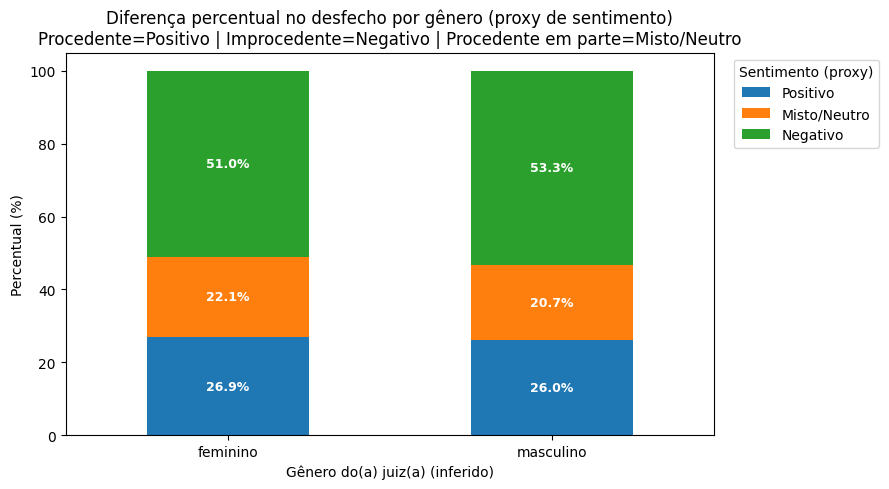

In [11]:
# ===================================================================================================
# [11] Diferença percentual no desfecho por Gênero
# ===================================================================================================

# ---------------------------------------------------------
# 11.1) Usa a base já "filtrada IBGE"
# ---------------------------------------------------------
df = df_final.copy()

# ---------------------------------------------------------
# 11.2) Normaliza a coluna de classificação
# ---------------------------------------------------------
df["_class_norm"] = (
    df["classificacao"]
      .astype(str)
      .str.upper()
      .str.strip()
      .replace({
          "PARCIALMENTE PROCEDENTE": "PROCEDENTE EM PARTE",
          "PROCEDENTE EM PARTE.": "PROCEDENTE EM PARTE"
      })
)

relevantes = ["IMPROCEDENTE", "PROCEDENTE", "PROCEDENTE EM PARTE"]
df = df[df["_class_norm"].isin(relevantes)].copy()

# ---------------------------------------------------------
# 11.3) Cria "sentimento" (proxy) a partir do desfecho
# ---------------------------------------------------------
sent_map = {
    "IMPROCEDENTE": "Negativo",
    "PROCEDENTE": "Positivo",
    "PROCEDENTE EM PARTE": "Misto/Neutro"
}
df["sentimento_proxy"] = df["_class_norm"].map(sent_map)

# ---------------------------------------------------------
# 11.4) Garante gênero padronizado e mantém apenas masc/fem
# ---------------------------------------------------------
df["genero_inferido"] = df["genero_inferido"].astype(str).str.lower().str.strip()
df = df[df["genero_inferido"].isin(["masculino", "feminino"])].copy()

# ---------------------------------------------------------
# 11.5) Tabela percentual por gênero
# ---------------------------------------------------------
tab_pct = pd.crosstab(df["genero_inferido"], df["sentimento_proxy"], normalize="index") * 100

ord_cols = ["Positivo", "Misto/Neutro", "Negativo"]
for c in ord_cols:
    if c not in tab_pct.columns:
        tab_pct[c] = 0.0
tab_pct = tab_pct[ord_cols].round(1)

display(tab_pct)

# ---------------------------------------------------------
# 11.6) Gráfico: barras empilhadas em %
# ---------------------------------------------------------

ax = tab_pct.plot(kind="bar", stacked=True, figsize=(9, 5))

ax.set_ylabel("Percentual (%)")
ax.set_xlabel("Gênero do(a) juiz(a) (inferido)")
ax.set_title(
    "Diferença percentual no desfecho por gênero (proxy de sentimento)\n"
    "Procedente=Positivo | Improcedente=Negativo | Procedente em parte=Misto/Neutro"
)

ax.legend(title="Sentimento (proxy)", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=0)

# -------------------------------------------------
# 11.7) INSERIR VALORES (%) DENTRO DAS BARRAS
# -------------------------------------------------
for container in ax.containers:
    for bar in container:
        altura = bar.get_height()
        if altura > 0:  # evita poluir com zeros
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + altura / 2,
                f"{altura:.1f}%",
                ha="center",
                va="center",
                fontsize=9,
                color="white",
                fontweight="bold"
            )

plt.tight_layout()
plt.show()

#### 12) Preparação Centralizada para Modelos de Análise de Sentimentos
> Objetivo: Preparar dados para a Análise de Sentimentos - Modelos nas seções seguintes.  
> - Padronização da entrada de dados: acentos normalizados; espaços limpos; sem retirar informações jurídicas importantes.  
> - A classificação já vira sentimento: Procedente = Positivo; Improcedente = Negativo; Procedente em Parte = Neutro.
> - Dados divididos em treino e teste.  

In [12]:
# ===================================================================================================
# [12] PREPARAÇÃO CENTRALIZADA PARA ANÁLISE DE SENTIMENTO (TRAIN/TEST SPLIT)
# ===================================================================================================

print("Iniciando preparação centralizada dos dados para análise de sentimento...")

# Agora a base correta vem da seção [10], já limpa e com genero_inferido
df = df_final.copy()

# --------------------------------------------------------------------------------------
# 12.1 — Verificação das colunas obrigatórias (versão nova, sem acentos)
# --------------------------------------------------------------------------------------
colunas_necessarias = ["trecho_da_sentenca", "classificacao", "juiz", "genero_inferido"]

for c in colunas_necessarias:
    if c not in df.columns:
        raise ValueError(
            f"A coluna obrigatória '{c}' NÃO existe no DataFrame.\n"
            f"Colunas disponíveis: {df.columns.tolist()}\n"
            f"Verifique as Seções [8], [9] e [10]."
        )

print("Todas as colunas necessárias foram encontradas.")

# --------------------------------------------------------------------------------------
# 12.2 — Função de limpeza leve (não destrutiva)
# --------------------------------------------------------------------------------------
def limpar_texto(s):
    if pd.isna(s):
        return ""
    s = str(s)
    s = re.sub(r"\s+", " ", s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    return s.strip()

df["texto_limpo"] = df["trecho_da_sentenca"].apply(limpar_texto)

# --------------------------------------------------------------------------------------
# 12.3 — Mapeamento da classificação → rótulos de sentimento
# --------------------------------------------------------------------------------------
mapa_sentimento = {
    "PROCEDENTE": "positivo",
    "IMPROCEDENTE": "negativo",
    "PROCEDENTE EM PARTE": "neutro"
}

# classificação já está padronizada em maiúsculo desde a Seção [8]
df["sentimento_label"] = df["classificacao"].map(mapa_sentimento)

print("Rótulos convertidos com sucesso (positivo / negativo / neutro).")
print("Valores únicos em sentimento_label:", df["sentimento_label"].unique())
print("Total de NaN:", df["sentimento_label"].isna().sum())

# --------------------------------------------------------------------------------------
# 12.4 — Split treino / teste
# --------------------------------------------------------------------------------------
X = df["texto_limpo"]
y = df["sentimento_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Split treino/teste realizado (80/20, estratificado).")

# --------------------------------------------------------------------------------------
# 12.5 — Vetorização TF-IDF (base para Naive Bayes)
# --------------------------------------------------------------------------------------
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=2,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF gerado com sucesso (unigram + bigram).")

# --------------------------------------------------------------------------------------
# 12.6 — Saída final da seção
# --------------------------------------------------------------------------------------
print("\n===== PREPARAÇÃO FINALIZADA COM SUCESSO =====")
print(f"Total de sentenças no dataset final: {len(df)}")

print("\nVariáveis disponíveis para os modelos:")
print(" - X_train_tfidf, X_test_tfidf  → usados no Naive Bayes")
print(" - X_train, X_test              → textos brutos (para modelos BERT/Transformers)")
print(" - y_train, y_test              → rótulos (positivo / negativo / neutro)")

display(df[["trecho_da_sentenca", "texto_limpo", "sentimento_label"]].head(3))

Iniciando preparação centralizada dos dados para análise de sentimento...
Todas as colunas necessárias foram encontradas.
Rótulos convertidos com sucesso (positivo / negativo / neutro).
Valores únicos em sentimento_label: ['negativo' 'positivo' 'neutro']
Total de NaN: 0
Split treino/teste realizado (80/20, estratificado).
TF-IDF gerado com sucesso (unigram + bigram).

===== PREPARAÇÃO FINALIZADA COM SUCESSO =====
Total de sentenças no dataset final: 1516

Variáveis disponíveis para os modelos:
 - X_train_tfidf, X_test_tfidf  → usados no Naive Bayes
 - X_train, X_test              → textos brutos (para modelos BERT/Transformers)
 - y_train, y_test              → rótulos (positivo / negativo / neutro)


,trecho_da_sentenca,texto_limpo,sentimento_label
0,"Pelo exposto, diante das razões expostas, dand...","Pelo exposto, diante das razoes expostas, dand...",negativo
1,Julgado procedente o pedido AUTOS N° 0000004-2...,Julgado procedente o pedido AUTOS N° 0000004-2...,positivo
2,"Diante do exposto, JULGO IMPROCEDENTES os pedi...","Diante do exposto, JULGO IMPROCEDENTES os pedi...",negativo


> Após as etapas de *scraping*, limpeza e pré-processamento, obteve-se um **conjunto final de 1.516 sentenças válidas**, utilizadas como base para o treinamento e avaliação dos modelos de análise de sentimento. Para garantir uma avaliação adequada da capacidade de generalização dos modelos, o *dataset* foi particionado em conjuntos de treino e teste, adotando-se a proporção de **80% para treinamento e 20% para teste**, com estratificação das classes. Dessa forma, **aproximadamente 1.212 sentenças foram utilizadas para o treinamento dos modelos, enquanto 304 sentenças compuseram o conjunto de teste**, reservado exclusivamente para a avaliação de desempenho.

#### 13) Análise de Sentimento – Modelo 1: "Naive Bayes" com TF-IDF  
> Nesta etapa, apresenta-se o desempenho do **modelo Naive Bayes com TF-IDF**, treinado a partir do conjunto de treinamento correspondente a aproximadamente 80% do *dataset* total e **avaliado exclusivamente sobre o conjunto de teste**, composto por 304 sentenças, o que representa cerca de 20% da base final de dados. Essa estratégia assegura que as métricas apresentadas reflitam a capacidade de generalização do modelo, evitando *vieses* decorrentes da avaliação em dados previamente vistos durante o treinamento.  

=== Treinando Modelo Naive Bayes (TF-IDF) ===

Treinamento concluído.

Predições geradas com sucesso.

===== RELATÓRIO DE DESEMPENHO — NAIVE BAYES (TF-IDF) =====


,precisão,recall,f1-score,suporte
negativo,0.874286,0.956250,0.913433,160.000000
neutro,0.848485,0.437500,0.577320,64.000000
positivo,0.697917,0.837500,0.761364,80.000000
acurácia,0.815789,0.815789,0.815789,0.815789
média simples,0.806896,0.743750,0.750705,304.000000
média ponderada,0.822441,0.815789,0.802654,304.000000



Acurácia geral do modelo: 81.58%



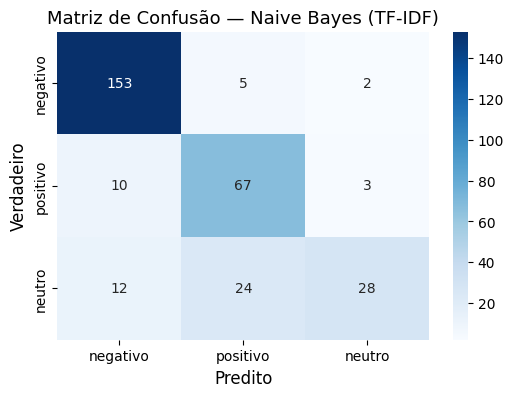


Matriz de confusão gerada com sucesso.


In [13]:
# ===================================================================================================
# [13] MODELO 1 — Naive Bayes (TF-IDF)
# ===================================================================================================

print("=== Treinando Modelo Naive Bayes (TF-IDF) ===\n")

# -----------------------------------------------------------------------------
# 13.1) Treinamento
# -----------------------------------------------------------------------------
modelo_nb = MultinomialNB()
modelo_nb.fit(X_train_tfidf, y_train)

print("Treinamento concluído.\n")

# -----------------------------------------------------------------------------
# 13.2) Predição
# -----------------------------------------------------------------------------
y_pred = modelo_nb.predict(X_test_tfidf)
print("Predições geradas com sucesso.\n")

# -----------------------------------------------------------------------------
# 13.3) Relatório de Classificação (PT-BR)
# -----------------------------------------------------------------------------
print("===== RELATÓRIO DE DESEMPENHO — NAIVE BAYES (TF-IDF) =====")

relatorio = classification_report(
    y_test,
    y_pred,
    target_names=["negativo", "neutro", "positivo"],
    digits=4,
    output_dict=True
)

# Converter para DataFrame (linhas = classes e métricas agregadas)
df_rel_nb = pd.DataFrame(relatorio).T

# -------- Renomear COLUNAS (métricas) --------
df_rel_nb = df_rel_nb.rename(columns={
    "precision": "precisão",
    "recall": "recall",
    "f1-score": "f1-score",
    "support": "suporte"
})

# -------- Renomear LINHAS (índices) --------
df_rel_nb = df_rel_nb.rename(index={
    "accuracy": "acurácia",
    "macro avg": "média simples",
    "weighted avg": "média ponderada"
})

# Exibir relatório
display(df_rel_nb)

# -----------------------------------------------------------------------------
# 13.4) Acurácia Geral em %
# -----------------------------------------------------------------------------
acuracia = accuracy_score(y_test, y_pred)
print(f"\nAcurácia geral do modelo: {acuracia * 100:.2f}%\n")

# -----------------------------------------------------------------------------
# 13.5) Matriz de Confusão
# -----------------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=["negativo", "positivo", "neutro"])

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["negativo", "positivo", "neutro"],
    yticklabels=["negativo", "positivo", "neutro"]
)

plt.xlabel("Predito", fontsize=12)
plt.ylabel("Verdadeiro", fontsize=12)
plt.title("Matriz de Confusão — Naive Bayes (TF-IDF)", fontsize=13)
plt.show()

print("\nMatriz de confusão gerada com sucesso.")

##### **Resultados do Modelo *Naive Bayes* (TF-IDF):**  

> <span style="color:#1f77b4">**Obs.: A matriz de confusão apresentada acima refere-se exclusivamente às predições realizadas sobre o *conjunto de teste*, permitindo analisar a distribuição de acertos e erros entre as classes negativo, positivo e neutro, a partir de dados não utilizados durante o treinamento do modelo**.</span>  
>   
> **O modelo Naive Bayes apresentou acurácia de 81,58% no conjunto de teste, calculada a partir das predições realizadas sobre 304 sentenças não utilizadas durante o treinamento. Esse resultado reflete o desempenho do modelo na tarefa de classificação de sentimento jurídico, considerando o particionamento adotado do *dataset***.
>         
> Os dados a seguir permitem analisar, de forma detalhada, o desempenho do modelo **Naive Bayes** em cada classe de sentimento:  
> **Negativo:** 153 casos negativos classificados corretamente; apenas 7 erros (5 para positivo e 2 para neutro). Isso significa que o modelo tem "quase certeza" ao identificar improcedência.    
> - Precisão: 0.8742 (quando o modelo diz `negativo`, ele está certo 87% das vezes).      
> - Recall: 0.9562 (o modelo identifica quase todos os casos realmente `negativos`). A alta taxa de recall sugere que muitas sentenças possuem estrutura redacional muito marcada, como “indeferir”, “não acolho”, “julgo improcedente”.   
> - F1-score: 0.9134 (cerca de 91% de desempenho médio entre precisão e recall).
>> - O modelo é muito bom para detectar sentenças improcedentes (`negativo`), mas às vezes classifica textos como `negativo` mesmo quando não são (falso positivo moderado).  
>
> **Positivo:** 67 casos `positivos` classificados corretamente; 10 casos confundidos com `negativo` e 3 casos confundidos com `neutro`.  
> - Precisão: 0.6979 (quando o modelo diz `positivo`, ele está certo 69% das vezes).  
> - Recall: 0.8375   
> - F1-score: 0.7613  
>> - O modelo acerta bem quando identifica `positivo`, mas ainda deixa passar cerca de 16% desses casos. Isso ocorre porque sentenças positivas e negativas compartilham vocabulário jurídico semelhante.  
>> - Sentenças `positivas` tendem a ser mais variadas (maior diversidade lexical), por exemplo: acolhimento parcial, reconhecimento de danos, fixação ou majoração de valores, revisão contratual, obrigações de fazer e não fazer.
>
> **Neutro:** 28 casos `neutros` classificados corretamente; 12 casos confundidos com `negativo` e 24 casos confundidos com `positivo`.  
> - Precisão: 0.8484  
> - Recall: 0.4375  
> - F1-score: 0.5773  
>> - O modelo acerta quando identifica neutro, mas perde muitos casos neutros (baixa taxa de recall). Ou seja, ele não reconhece neutralidade (procedente em parte) tão bem quanto reconhece procedência/improcedência. A maior fonte de erro é confundir neutro com positivo — comportamento esperado porque decisões parcialmente procedentes frequentemente usam linguagem semelhante às totalmente procedentes.  
>
> **Pontos Fortes do Modelo:** Excelente para identificar improcedência (`negativo`); Resultado sólido para um baseline inicial; Execução rápida, leve e eficiente; Boa acurácia geral considerando linguagem jurídica altamente técnica.  
> **Pontos a Melhorar:** Desempenho moderado na classe `positivo`; Dificuldade em separar `neutro` (procedente em parte) de `positivo`; Forte sobreposição lexical entre classes dificulta distinção para modelos baseados apenas em palavras.  
> **Conclusão:** O modelo Naive Bayes apresentou boa acurácia geral (81,58%), destacando-se no reconhecimento de sentenças classificadas como improcedentes, onde alcança desempenho excepcional. Por outro lado, demonstrou dificuldade em diferenciar textos neutros e positivos, reflexo natural da forte sobreposição lexical na linguagem jurídica e do modelo não considerar contexto semântico. Os resultados justificam plenamente a aplicação de modelos contextuais baseados em *transformers* (como BERT) para melhorar a distinção entre procedente, procedente em parte e improcedente e aumentar a robustez da análise de sentimento jurídica.  

#### 14) Análise de Sentimento – Modelo 2: BERT (Pré-treinado - sem *fine-tuning*)  
> Nesta etapa, apresenta-se o desempenho do **modelo mBERT**, treinado a partir do conjunto de treinamento correspondente a aproximadamente 80% do *dataset* total e **avaliado exclusivamente sobre o conjunto de teste**, composto por 304 sentenças, o que representa cerca de 20% da base final de dados. Essa estratégia assegura que as métricas apresentadas reflitam a capacidade de generalização do modelo, evitando *vieses* decorrentes da avaliação em dados previamente vistos durante o treinamento.  

Iniciando Modelo pré-treinado BERT multilíngue...

Carregando modelo 'nlptown/bert-base-multilingual-uncased-sentiment'... (pode demorar alguns instantes)

Modelo carregado com sucesso!

Gerando predições no conjunto de teste...

Predições concluídas.

===== RELATÓRIO DE DESEMPENHO — BERT MULTILÍNGUE (SEM FINE-TUNING) =====



,precisão,recall,f1-score,suporte
negativo,0.528239,0.993750,0.689805,160.000000
neutro,0.333333,0.015625,0.029851,64.000000
positivo,0.000000,0.000000,0.000000,80.000000
acurácia,0.526316,0.526316,0.526316,0.526316
média simples,0.287191,0.336458,0.239885,304.000000
média ponderada,0.348196,0.526316,0.369340,304.000000



Acurácia geral: 0.5263  (52.63%)

Gerando matriz de confusão...



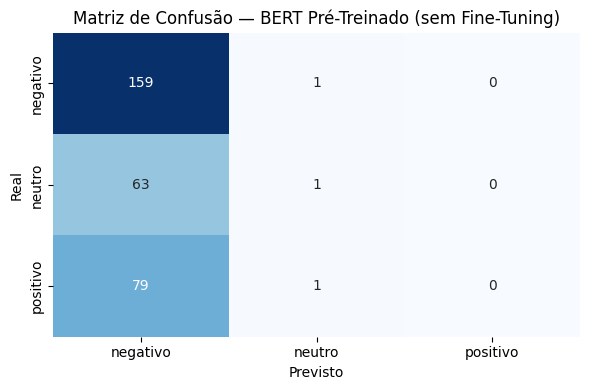

Matriz de confusão gerada com sucesso!


In [14]:
# ===================================================================================================
# [14] MODELO 2 - BERT MULTILÍNGUE (PRÉ-TREINADO — SEM FINE-TUNING)
# ===================================================================================================

print("Iniciando Modelo pré-treinado BERT multilíngue...\n")

# ===================================================================================================
# Ocultar warnings do sklearn e transformers
# ===================================================================================================
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)

# ===================================================================================================
# 14.1 — Carregar pipeline pré-treinado
# ===================================================================================================
print("Carregando modelo 'nlptown/bert-base-multilingual-uncased-sentiment'... (pode demorar alguns instantes)\n")

sentiment_model = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",  # modelo hugging face
    truncation=True
)

print("Modelo carregado com sucesso!\n")

# ===================================================================================================
# 14.2 — Preparar textos
# ===================================================================================================
X_test_texts = X_test.tolist()
y_test_true = y_test.tolist()

# ===================================================================================================
# 14.3 — Converter estrelas (1–5) → negativo / neutro / positivo
# ===================================================================================================
def mapear_nota_para_label(pred):
    label = pred["label"]
    estrela = int(label.split()[0])

    if estrela <= 2:
        return "negativo"
    elif estrela == 3:
        return "neutro"
    else:
        return "positivo"

# ===================================================================================================
# 14.4 — Gerar predições
# ===================================================================================================
print("Gerando predições no conjunto de teste...\n")

predicoes_raw = sentiment_model(X_test_texts)
y_pred = [mapear_nota_para_label(p) for p in predicoes_raw]

print("Predições concluídas.\n")

# Para permitir comparação entre modelos na seção [15]
y_pred_bert = y_pred

# ===================================================================================================
# 14.5 — RELATÓRIO TRADUZIDO PARA PORTUGUÊS BRASIL
# ===================================================================================================
print("===== RELATÓRIO DE DESEMPENHO — BERT MULTILÍNGUE (SEM FINE-TUNING) =====\n")

rel = classification_report(
    y_test_true,
    y_pred,
    target_names=["negativo", "neutro", "positivo"],
    zero_division=0,
    output_dict=True
)

# Converter para DataFrame — AGORA COM NOME CORRETO
df_rel_bert = pd.DataFrame(rel).T

# Renomear colunas para PT-BR
df_rel_bert = df_rel_bert.rename(columns={
    "precision": "precisão",
    "recall": "recall",
    "f1-score": "f1-score",
    "support": "suporte"
})

# Renomear linhas (accuracy, macro avg, weighted avg)
df_rel_bert = df_rel_bert.rename(index={
    "accuracy": "acurácia",
    "macro avg": "média simples",
    "weighted avg": "média ponderada"
})

display(df_rel_bert)

# ===================================================================================================
# Acurácia geral com duas casas decimais entre parênteses
# ===================================================================================================
acuracia_bert = float(df_rel_bert.loc["acurácia", "precisão"])
print(f"\nAcurácia geral: {acuracia_bert:.4f}  ({acuracia_bert*100:.2f}%)")

# ===================================================================================================
# 14.6 — MATRIZ DE CONFUSÃO
# ===================================================================================================
print("\nGerando matriz de confusão...\n")

cm = confusion_matrix(y_test_true, y_pred, labels=["negativo", "neutro", "positivo"])

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["negativo", "neutro", "positivo"],
    yticklabels=["negativo", "neutro", "positivo"],
    cbar=False
)

plt.title("Matriz de Confusão — BERT Pré-Treinado (sem Fine-Tuning)", fontsize=12)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

print("Matriz de confusão gerada com sucesso!")

##### **Resultados do Modelo BERT Multilíngue sem *Fine-Tuning***  

> <span style="color:#1f77b4">**Obs.: Embora o modelo mBERT seja um modelo pré-treinado em larga escala, sua avaliação neste estudo seguiu a mesma estratégia metodológica adotada para os modelos clássicos, utilizando exclusivamente o conjunto de teste composto por 304 sentenças. Tal escolha visa garantir comparabilidade entre os modelos avaliados, bem como assegurar uniformidade nos critérios de avaliação.** </span>  
>   
> **O modelo mBERT apresentou acurácia de 52,63% no conjunto de teste, calculada a partir das predições realizadas sobre 304 sentenças não utilizadas durante o treinamento. Esse resultado indica desempenho inferior ao observado nos modelos clássicos, sugerindo limitações na aplicação direta do mBERT, sem fine-tuning, à tarefa específica de classificação de sentimento jurídico no contexto analisado.**  
>  
> Os dados a seguir permitem analisar, de forma detalhada, o desempenho do modelo **mBERT** em cada classe de sentimento:  
> **Negativo:** O modelo classificou 159 casos `negativos` corretamente e 1 caso apenas como neutro. Mas isso ocorreu porque ele classificou praticamente todas as sentenças como negativas, independentemente do conteúdo. Isso significa que o modelo não simplesmente não consegue distinguir nenhuma outra classe e colapsa para o rótulo majoritário.        
> - Precisão: 0.5282 (quando o modelo diz “negativo”, ele só acerta porque escolhe negativo para todos os casos).      
> - Recall: 0.9937 (ele acerta todos os negativos porque praticamente tudo é classificado como negativo).  
> - F1-score: 0.6898 (reflete um bom equilíbrio matemático, mas não significa compreensão do texto).    
>> Apesar da métrica alta, o desempenho é ilusório, já que o modelo apresenta comportamento colapsado: incapaz de classificar qualquer outra categoria.
>  
> **Positivo:** O modelo não identificou nenhum dos casos como `positivo`.      
> - Precisão: 0.00  
> - Recall: 0.00     
> - F1-score: 0.00
>> O modelo não reconhece vocabulário associado ao resultado “procedente”, como: “acolho”, "julgo procedente", "procedência", "declaro direito do autor". A ausência completa de acertos mostra que um BERT sem treinamento especializado em textos jurídicos não possui qualquer entendimento contextual útil para diferenciar decisões favoráveis.   
>  
> **Neutro:** O modelo só identificou 1 caso como `neutros` (procedente em parte).      
> - Precisão: 0.3333  
> - Recall: 0.0156     
> - F1-score: 0.0298      
>> O modelo não distingue expressões típicas de parcial procedência, como: "julgo parcialmente procedente", "acolho em parte", "procedência parcial".
>  
> **Pontos Forte do Modelo:** Acerta todas as sentenças negativas, mas apenas porque classifica tudo como negativo. Serve como baseline mínimo para comparar com modelos ajustados.  
> **Pontos a Melhorar:** Incapacidade total de identificar sentenças positivas; Incapacidade total de identificar sentenças neutras; Colapso para uma única classe, comportamento típico de modelos grandes sem fine-tuning; Linguagem jurídica é altamente técnica, e o modelo não foi treinado nessa distribuição.      
> **Conclusão:** O modelo BERT Multilíngue sem fine-tuning apresentou desempenho muito inferior (52,63% de acurácia), classificando todas as sentenças como negativas. Apesar de ser um modelo extremamente poderoso, ele não consegue interpretar decisões judiciais brasileiras sem treinamento específico no domínio (Os resultados reforçam a necessidade de aplicar fine-tuning no dataset jurídico).  

#### 15) Análise de Sentimento – Modelo 3: Logistic Regression (TF-IDF)  
> Nesta etapa, apresenta-se o desempenho do **modelo de Regressão Logística (TF-IDF)**, treinado a partir do conjunto de treinamento correspondente a aproximadamente 80% do *dataset* total e **avaliado exclusivamente sobre o conjunto de teste**, composto por 304 sentenças, o que representa cerca de 20% da base final de dados. Essa estratégia assegura que as métricas apresentadas reflitam a capacidade de generalização do modelo, evitando *vieses* decorrentes da avaliação em dados previamente vistos durante o treinamento.

=== Treinando Modelo de Regressão Logística (TF-IDF) ===

Treinamento concluído.

Predições geradas com sucesso.

===== RELATÓRIO DE DESEMPENHO — REGRESSÃO LOGÍSTICA (TF-IDF) =====



,precisão,recall,f1-score,suporte
negativo,0.938650,0.956250,0.947368,160.000000
neutro,0.901961,0.718750,0.800000,64.000000
positivo,0.788889,0.887500,0.835294,80.000000
acurácia,0.888158,0.888158,0.888158,0.888158
média simples,0.876500,0.854167,0.860888,304.000000
média ponderada,0.891515,0.888158,0.886850,304.000000



Acurácia geral do modelo (Regressão Logística): 0.8882 (88.82%)



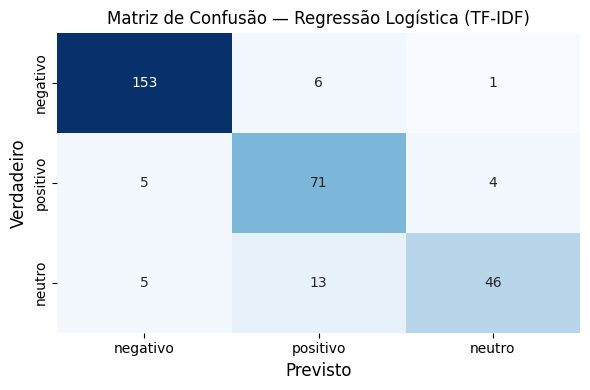

Matriz de confusão gerada com sucesso.


In [15]:
# ===================================================================================================
# [15] MODELO 3 — Regressão Logística (TF-IDF)
# ===================================================================================================

print("=== Treinando Modelo de Regressão Logística (TF-IDF) ===\n")

# -----------------------------------------------------------------------------
# 15.1 — Treinamento
# -----------------------------------------------------------------------------
# Usa a mesma representação TF-IDF preparada na Seção [11]
modelo_lr = LogisticRegression(
    max_iter=2000,
    n_jobs=1,              # <<< ESSENCIAL NO WINDOWS!
    class_weight="balanced",
    solver="liblinear"     # solver mais seguro para TF-IDF + 3 classes pequenas
)

modelo_lr.fit(X_train_tfidf, y_train)

print("Treinamento concluído.\n")

# -----------------------------------------------------------------------------
# 15.2 — Predição
# -----------------------------------------------------------------------------
y_pred_lr = modelo_lr.predict(X_test_tfidf)
print("Predições geradas com sucesso.\n")

# -----------------------------------------------------------------------------
# 15.3 — Relatório de Desempenho (PT-BR)
# -----------------------------------------------------------------------------
print("===== RELATÓRIO DE DESEMPENHO — REGRESSÃO LOGÍSTICA (TF-IDF) =====\n")

rel_lr = classification_report(
    y_test,
    y_pred_lr,
    target_names=["negativo", "neutro", "positivo"],
    digits=4,
    output_dict=True
)

# Converte para DataFrame específico deste modelo
df_rel_lr = pd.DataFrame(rel_lr).T

# Renomeia colunas para português
df_rel_lr = df_rel_lr.rename(columns={
    "precision": "precisão",
    "recall": "recall",
    "f1-score": "f1-score",
    "support": "suporte"
})

# Renomeia linhas agregadas
df_rel_lr = df_rel_lr.rename(index={
    "accuracy": "acurácia",
    "macro avg": "média simples",     # média simples entre classes
    "weighted avg": "média ponderada" # ponderada pelo nº de amostras em cada classe
})

display(df_rel_lr)

# Acurácia geral (em % com 2 casas decimais)
acuracia_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nAcurácia geral do modelo (Regressão Logística): {acuracia_lr:.4f} ({acuracia_lr*100:.2f}%)\n")

# -----------------------------------------------------------------------------
# 15.4 — Matriz de Confusão
# -----------------------------------------------------------------------------
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=["negativo", "positivo", "neutro"])

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["negativo", "positivo", "neutro"],
    yticklabels=["negativo", "positivo", "neutro"],
    cbar=False
)

plt.xlabel("Previsto", fontsize=12)
plt.ylabel("Verdadeiro", fontsize=12)
plt.title("Matriz de Confusão — Regressão Logística (TF-IDF)", fontsize=12)
plt.tight_layout()
plt.show()

print("Matriz de confusão gerada com sucesso.")

##### **Resultados do Modelo Regressão Logística (TF-IDF)**  

> <span style="color:#1f77b4">**Obs.: A matriz de confusão apresentada acima refere-se exclusivamente às predições realizadas sobre o *conjunto de teste*, permitindo analisar a distribuição de acertos e erros entre as classes negativo, positivo e neutro, a partir de dados não utilizados durante o treinamento do modelo**. </span>  
>   
> **O modelo de Regressão Logística, utilizando representação TF-IDF, apresentou acurácia de 88,82% no conjunto de teste, calculada a partir das predições realizadas sobre 304 sentenças não utilizadas durante o treinamento. Esse resultado indica desempenho superior em relação aos demais modelos avaliados, evidenciando a eficácia da combinação entre vetorização TF-IDF e classificação linear para a tarefa de análise de sentimento em sentenças judiciais.**          
>  
> Os dados a seguir permitem analisar, de forma detalhada, o desempenho do modelo **Regressão Logística (TF-IDF)** em cada classe de sentimento:  
> **Negativo:** O modelo classifica corretamente a maioria das sentenças `negativas` (153 casos negativos classificados corretamente).      
> - Precisão: 0.9386 (quando o modelo prevê `negativo`, ele está certo 93,8% das vezes).    
> - Recall: 0.9562 (o modelo identifica quase todos os casos realmente `negativos`).    
> - F1-score: 0.9473 (excelente equilíbrio entre precisão e recall).  
>> O modelo raramente erra quando prevê NEGATIVO e consegue capturar quase todas as sentenças realmente negativas.  
>
> **Positivo:** O modelo também foi sólido para esta classe (71 casos `positivos` classificados corretamente).    
> - Precisão: 0.7888  
> - Recall: 0.8875    
> - F1-score: 0.8352
>> O desempenho é muito forte: Quando o modelo prevê positivo, ele acerta quase 79% das vezes. Mesmo assim, existe pequena confusão com negativo — esperado, já que sentenças procedentes e improcedentes compartilham expressões jurídicas próximas, variando apenas o sentido do dispositivo.        
>
> **Neutro:** O modelo apresentou ótimo desempenho, mesmo sendo uma classe mais difícil (46 casos neutros classificados corretamente).    
> - Precisão: 0.9019  
> - Recall: 0.7187 (o recall de 72% mostra que ele entende bem o padrão textual de sentenças parcialmente procedentes — algo que modelos mais simples geralmente falham em capturar).     
> - F1-score: 0.8000
>> Surpreendentemente, este modelo se sai muito melhor que o Naive Bayes na detecção da classe neutro.    
>
> **Conclusão:** O modelo Regressão Logística com TF-IDF apresenta desempenho excepcional para análise de sentimento jurídico, alcançando 88,82% de acurácia geral e métricas robustas em todas as classes.  

#### 16) Comparação entre os 3 Modelos: Naive Bayes, BERT (sem Fine-Tuning) e Regressão Logística



      COMPARAÇÃO ENTRE OS MODELOS



,precisão,recall,f1-score,suporte
negativo,87.43%,95.62%,91.34%,160
neutro,84.85%,43.75%,57.73%,64
positivo,69.79%,83.75%,76.14%,80
acurácia,81.58%,81.58%,81.58%,0
média simples,80.69%,74.38%,75.07%,304
média ponderada,82.24%,81.58%,80.27%,304
,precisão,recall,f1-score,suporte
negativo,93.87%,95.62%,94.74%,160
neutro,90.2%,71.88%,80.0%,64
positivo,78.89%,88.75%,83.53%,80


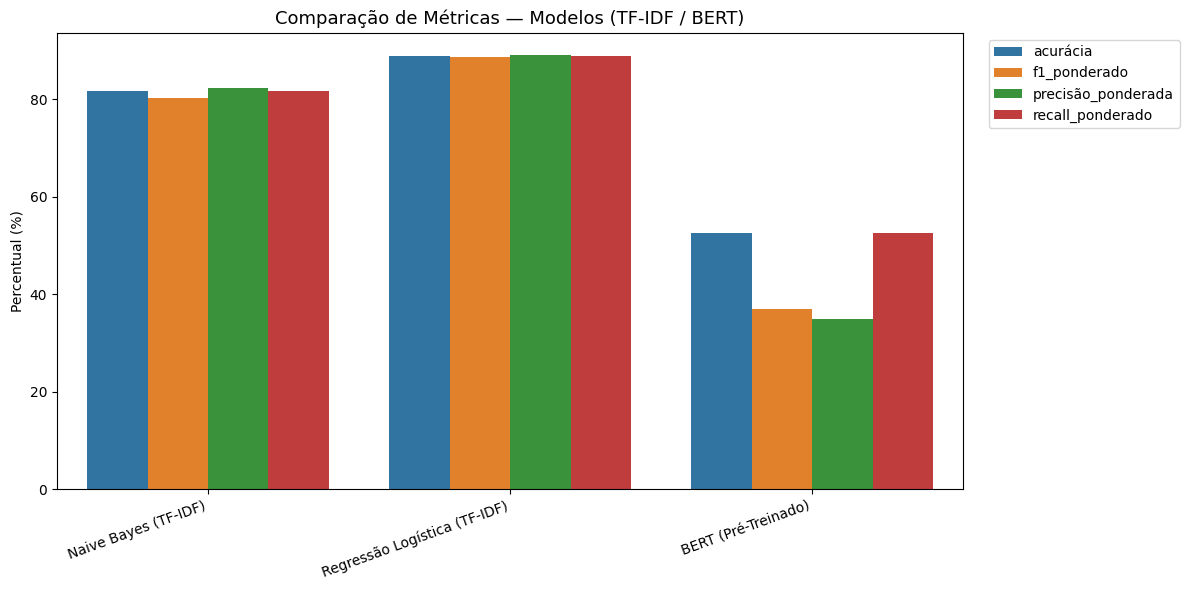


Comparação concluída com sucesso!


In [16]:
# ===================================================================================================
# [16] COMPARAÇÃO ENTRE MODELOS — Naive Bayes, Regressão Logística e BERT
# ===================================================================================================

print("\n\n============================================")
print("      COMPARAÇÃO ENTRE OS MODELOS")
print("============================================\n")

# ======================================================================================
# 16.1) Função utilitária para formatar tabelas (% e suporte como inteiro sem casas decimais)
# ======================================================================================

def formatar_metricas(df):
    df_formatado = df.copy()

    # Colunas que viram porcentagem
    cols_pct = ["precisão", "recall", "f1-score"]

    for col in cols_pct:
        if col in df_formatado.columns:
            df_formatado[col] = (df_formatado[col] * 100).round(2).astype(str) + "%"

    # Suporte deve ser inteiro limpo
    if "suporte" in df_formatado.columns:
        df_formatado["suporte"] = df_formatado["suporte"].astype(int)

    return df_formatado

# ======================================================================================
# 16.2) Garantir que os relatórios dos modelos existam
# ======================================================================================

if "df_rel_nb" not in globals():
    raise ValueError("[ERRO] df_rel_nb não encontrado. Execute as seções anteriores.")

if "df_rel_lr" not in globals():
    raise ValueError("[ERRO] df_rel_lr não encontrado. Execute as seções anteriores.")

usar_bert = "df_rel_bert" in globals()

# ======================================================================================
# 16.3) Formatar tabelas com percentuais
# ======================================================================================

df_rel_nb_fmt = formatar_metricas(df_rel_nb)
df_rel_lr_fmt = formatar_metricas(df_rel_lr)
df_rel_bert_fmt = formatar_metricas(df_rel_bert) if usar_bert else None

# ======================================================================================
# 16.4) HTML das tabelas — lado a lado
# ======================================================================================

html_nb = df_rel_nb_fmt.to_html()
html_lr = df_rel_lr_fmt.to_html()
html_bert = df_rel_bert_fmt.to_html() if usar_bert else "<p>BERT não disponível</p>"

html_tabelas = f"""
<table style="width:100%; table-layout: fixed; border-collapse: separate; border-spacing: 25px;">
<tr>
    <td style="vertical-align: top; width: 33%;">
        <h3 style='text-align:center;'>Naive Bayes (TF-IDF)</h3>
        {html_nb}
    </td>
    <td style="vertical-align: top; width: 33%;">
        <h3 style='text-align:center;'>Regressão Logística (TF-IDF)</h3>
        {html_lr}
    </td>
    <td style="vertical-align: top; width: 33%;">
        <h3 style='text-align:center;'>BERT (Pré-Treinado)</h3>
        {html_bert}
    </td>
</tr>
</table>
"""

display(HTML(html_tabelas))

# ======================================================================================
# 16.5) MÉTRICAS PARA GRÁFICO DE COMPARAÇÃO
# ======================================================================================

metricas = {
    "modelo": [],
    "acurácia": [],
    "f1_ponderado": [],
    "precisão_ponderada": [],
    "recall_ponderado": []
}

# ----------------------------
# 16.6) Valores — Naive Bayes
# ----------------------------
metricas["modelo"].append("Naive Bayes (TF-IDF)")
metricas["acurácia"].append(df_rel_nb.loc["acurácia", "precisão"])
metricas["f1_ponderado"].append(df_rel_nb.loc["média ponderada", "f1-score"])
metricas["precisão_ponderada"].append(df_rel_nb.loc["média ponderada", "precisão"])
metricas["recall_ponderado"].append(df_rel_nb.loc["média ponderada", "recall"])

# ----------------------------
# 16.7) Valores — Regressão Logística
# ----------------------------
metricas["modelo"].append("Regressão Logística (TF-IDF)")
metricas["acurácia"].append(df_rel_lr.loc["acurácia", "precisão"])
metricas["f1_ponderado"].append(df_rel_lr.loc["média ponderada", "f1-score"])
metricas["precisão_ponderada"].append(df_rel_lr.loc["média ponderada", "precisão"])
metricas["recall_ponderado"].append(df_rel_lr.loc["média ponderada", "recall"])

# ----------------------------
# 16.8) Valores — BERT (opcional)
# ----------------------------
if usar_bert:
    metricas["modelo"].append("BERT (Pré-Treinado)")

    metricas["acurácia"].append(df_rel_bert.loc["acurácia", "precisão"])
    metricas["f1_ponderado"].append(df_rel_bert.loc["média ponderada", "f1-score"])
    metricas["precisão_ponderada"].append(df_rel_bert.loc["média ponderada", "precisão"])
    metricas["recall_ponderado"].append(df_rel_bert.loc["média ponderada", "recall"])

df_metricas = pd.DataFrame(metricas)

# Converter para %
df_metricas.iloc[:, 1:] = df_metricas.iloc[:, 1:].astype(float) * 100

# ======================================================================================
# 16.9) GRÁFICO FINAL COMPARATIVO
# ======================================================================================

plt.figure(figsize=(12, 6))
df_metricas_melt = df_metricas.melt(id_vars="modelo", var_name="métrica", value_name="valor")

sns.barplot(
    data=df_metricas_melt,
    x="modelo",
    y="valor",
    hue="métrica"
)

plt.title("Comparação de Métricas — Modelos (TF-IDF / BERT)", fontsize=13)
plt.ylabel("Percentual (%)")
plt.xlabel("")
plt.xticks(rotation=20, ha="right")

# Legenda fora da área do gráfico
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

print("\nComparação concluída com sucesso!")

##### **Resultados da Comparação entre os 3 modelos**  
> 
> Os resultados obtidos evidenciam diferenças significativas de desempenho entre os modelos avaliados para a tarefa de análise de sentimento em sentenças judiciais. O **modelo mBERT multilíngue pré-treinado, utilizado sem etapa de ajuste fino (*fine-tuning*)**, apresentou **acurácia de 52,63% no conjunto de teste**, desempenho inferior aos modelos clássicos. Tal resultado sugere limitações na aplicação direta de modelos de linguagem geral a tarefas especializadas no domínio jurídico, em especial quando não há adaptação ao vocabulário, à estrutura sintática e às convenções discursivas próprias das decisões judiciais. A distribuição das predições indica dificuldade do modelo em discriminar adequadamente entre as classes procedente, improcedente e procedente em parte, reforçando a necessidade de especialização do modelo ao domínio analisado.
> Em contraste, os **modelos clássicos baseados em vetorização TF-IDF** apresentaram desempenho substancialmente superior. O **Naive Bayes alcançou acurácia de 81,58% no conjunto de teste**, demonstrando boa capacidade de generalização e desempenho particularmente robusto na identificação de sentenças improcedentes.
> O **modelo de Regressão Logística com TF-IDF apresentou o melhor desempenho entre os algoritmos avaliados, atingindo acurácia de 88,82%**, além de métricas equilibradas de precisão, recall e F1-score em todas as classes. Esse resultado indica que modelos lineares bem ajustados, aliados a representações vetoriais adequadas, permanecem altamente eficazes para tarefas de processamento de linguagem natural em contextos jurídicos caracterizados por forte padronização linguística e recorrência terminológica.    
> <span style="color:#1f77b4">**De forma geral, os achados deste trabalho reforçam que abordagens clássicas de aprendizado supervisionado ainda constituem soluções competitivas e eficientes para análise de sentimento jurídico. Ao mesmo tempo, os resultados obtidos com o mBERT apontam para oportunidades de ganho futuro por meio do treinamento ou ajuste fino de modelos baseados em *Transformers* sobre corpora jurídicos específicos, o que pode permitir a captura mais precisa de nuances semânticas e contextuais presentes nas decisões judiciais.** </span>   